In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import numpy.linalg as la
import numpy.ma as ma
import scipy.optimize as opt
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time

import push_pull as pp
import noise_models as noise

sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

,dataset,construct,model
0,E+E,E+E,push
1,I+E,I+E,push
2,RR+A,RR+A,push
3,S+A,S+A,push
4,S+E,S+E,push


96261 / 96261


WT_anti_exp  ST_anti_exp  SpT_anti_exp  Sp_frac_anti_exp
dataset                                                                 
E+E     0       5993.989258  6394.181152   8649.121094          1.352655
        1        484.283875   664.000793    564.378601          0.849967
        2        605.894165   737.394714     91.147232          0.123607
        3        803.416565   333.886597    168.033020          0.503264
        4       3100.157715   131.973206     60.481567          0.458287
...                     ...          ...           ...               ...
S+E     18757   1177.671265   390.252075    400.376099          1.025942
        18758   1190.564575    81.183945    158.838196          1.956522
        18759  11397.416992  1473.975220    342.042755          0.232055
        18760   1293.171875   652.249451    481.467163          0.738164
        18761    322.256653   336.612762     55.410645          0.164612

[96261 rows x 4 columns]

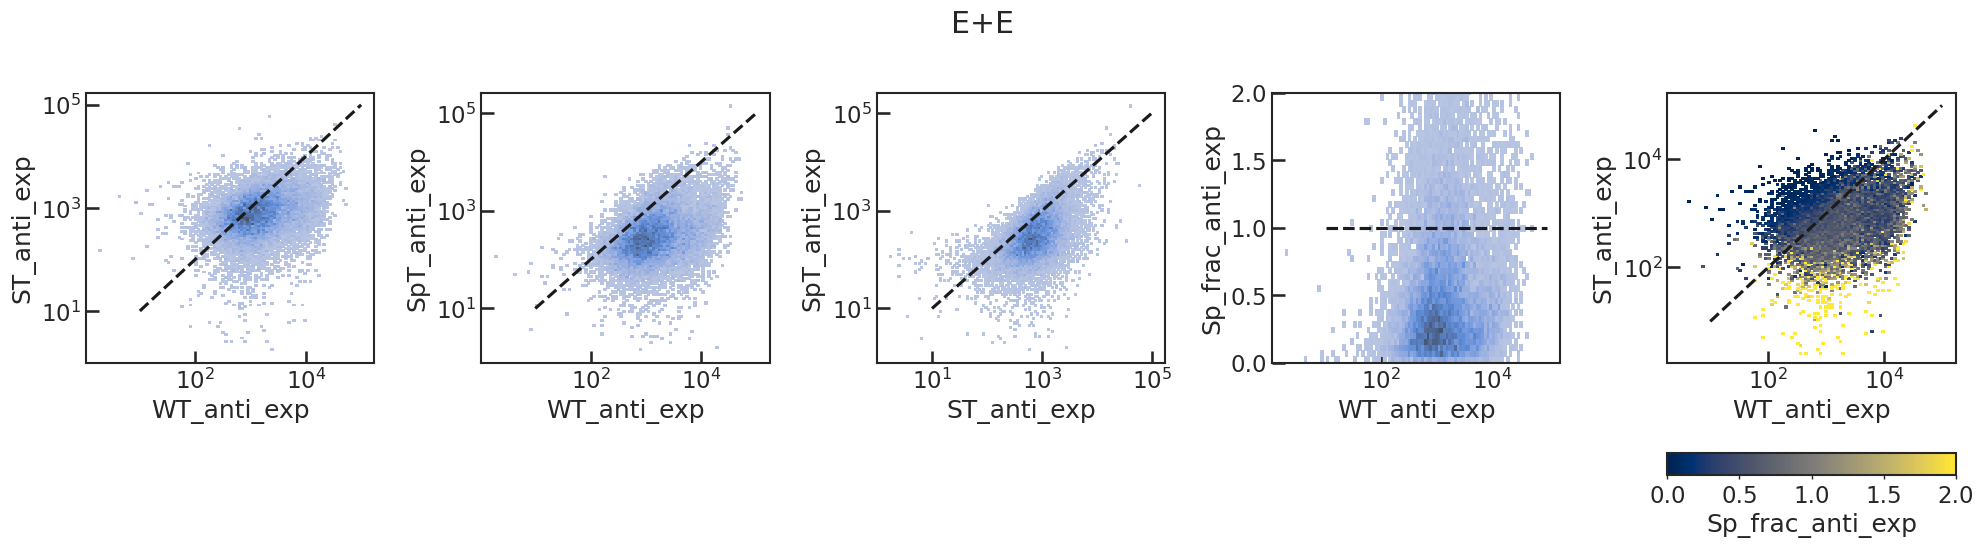

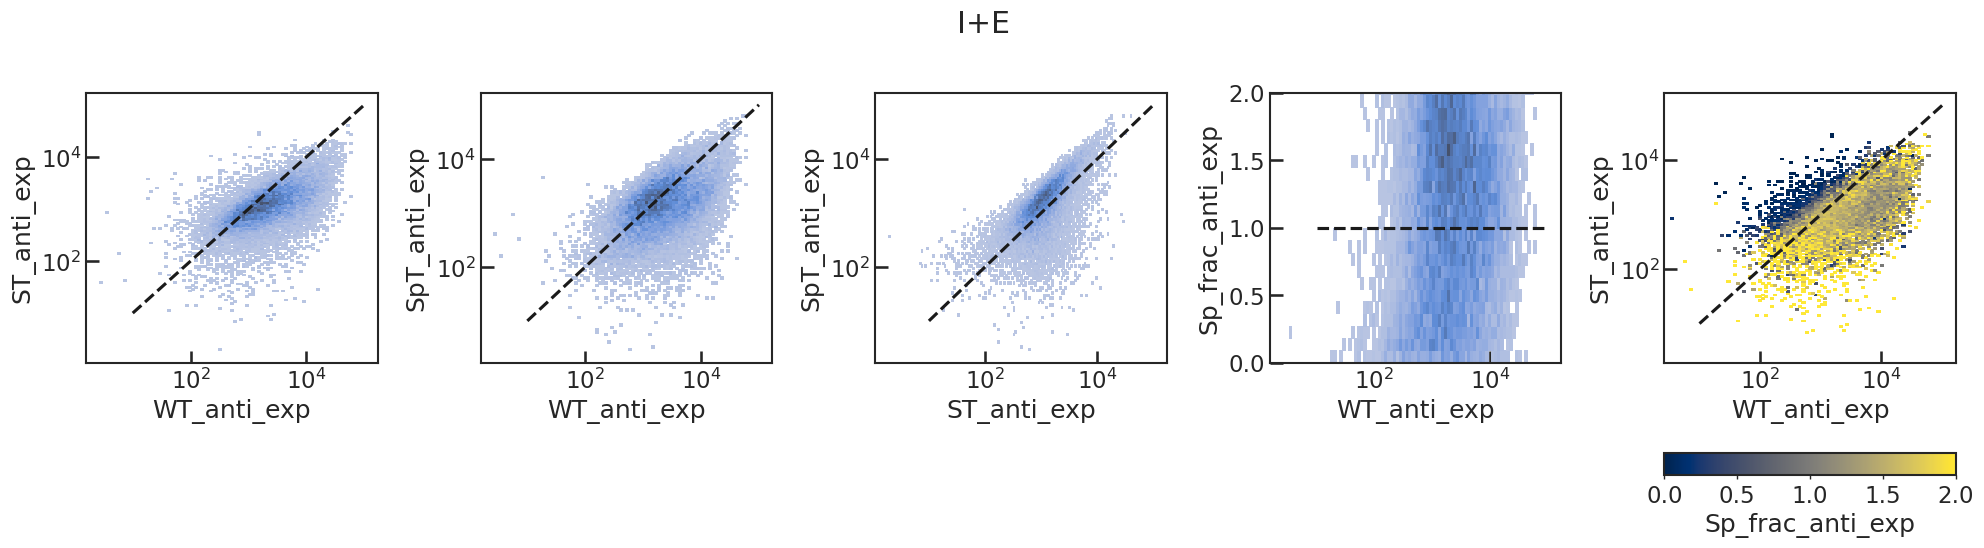

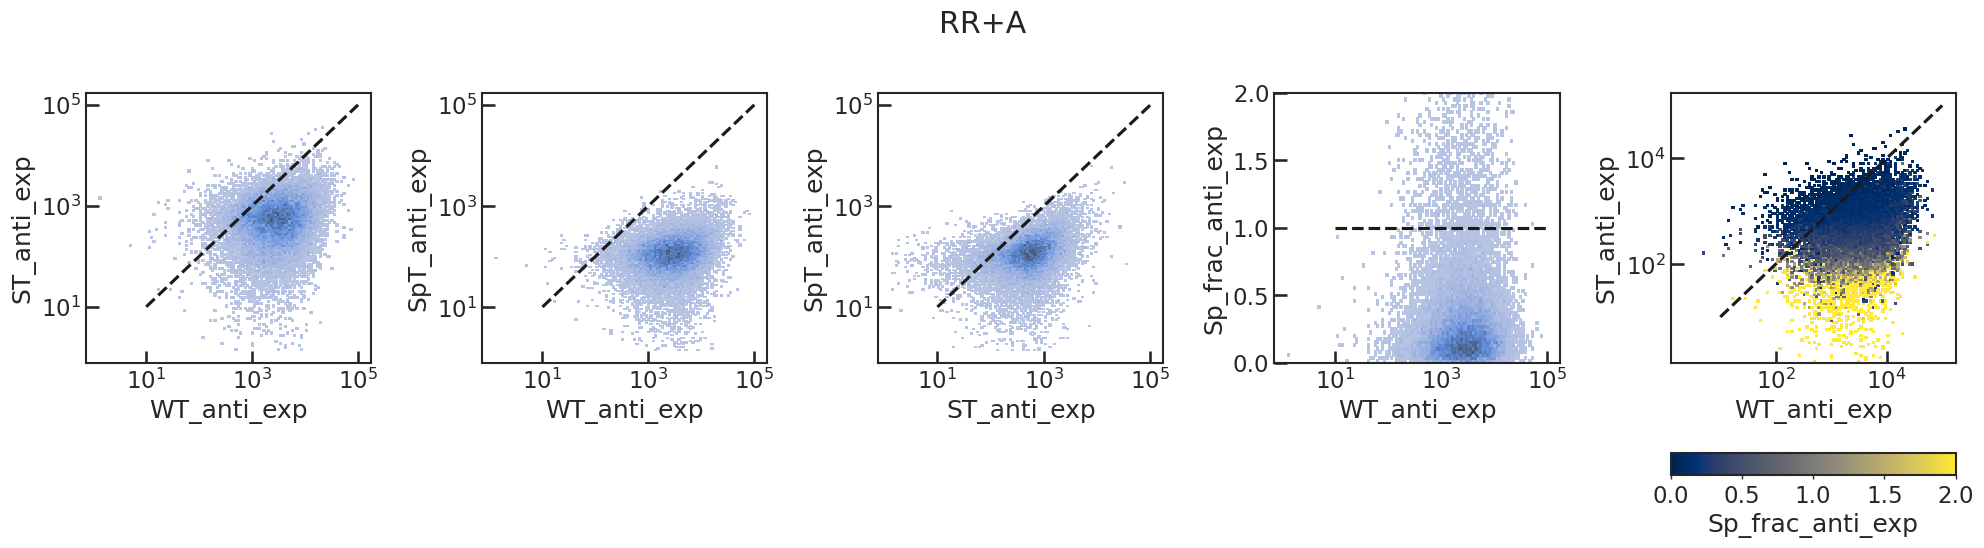

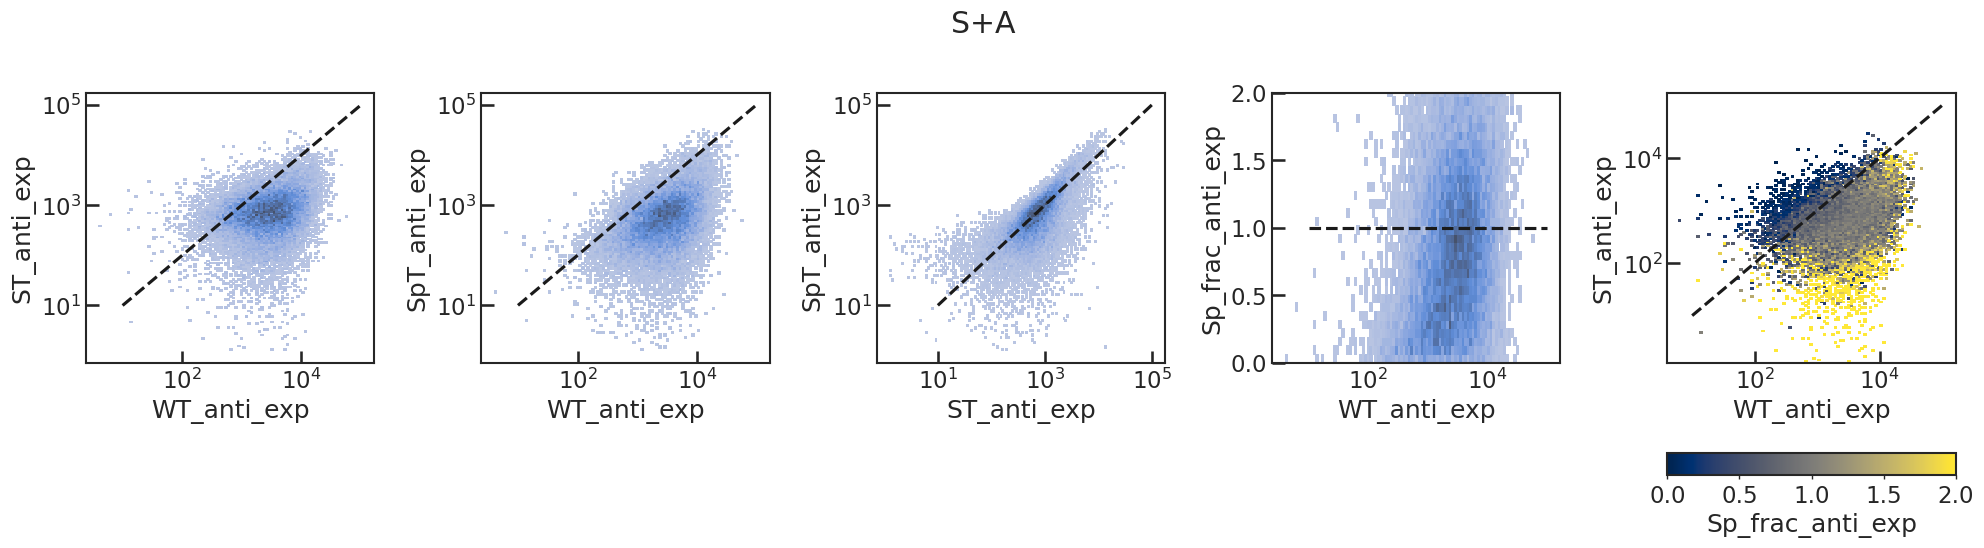

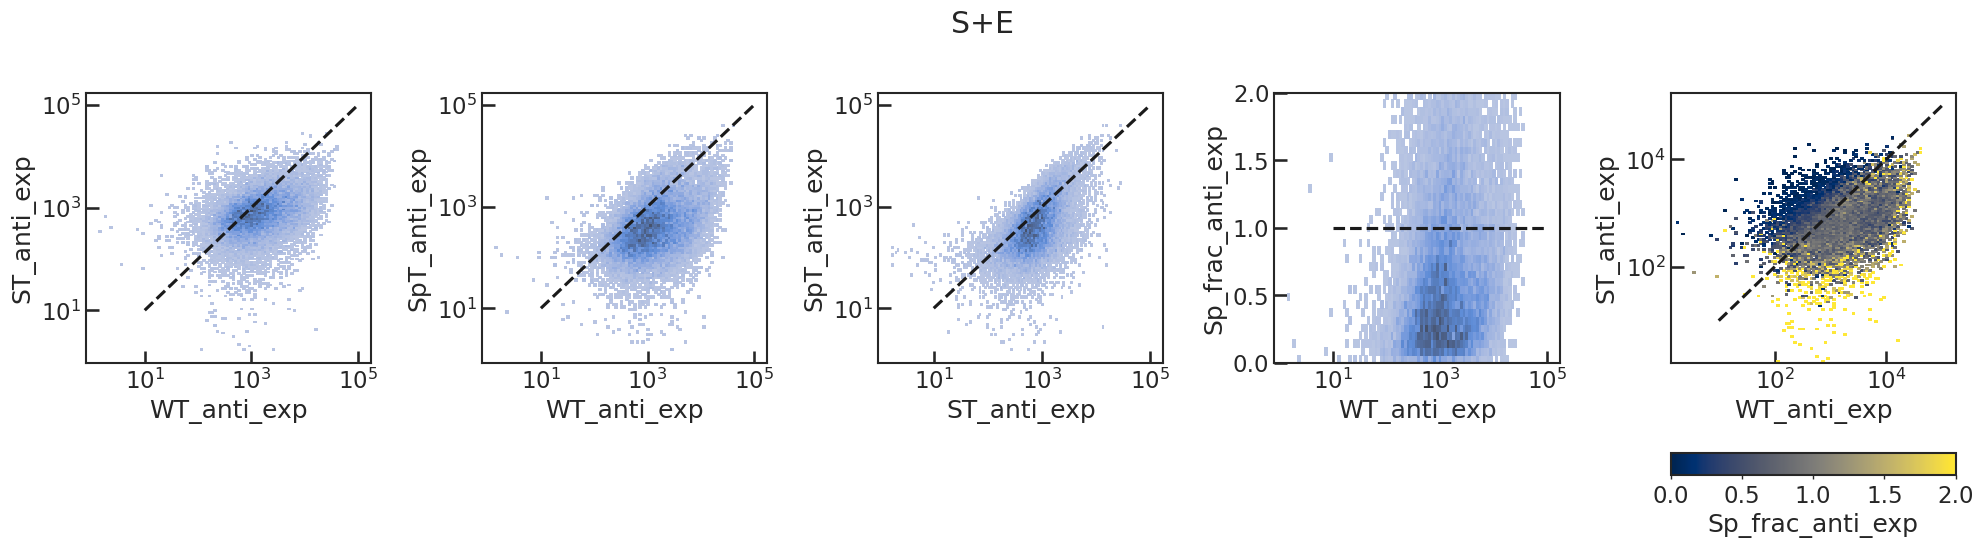

In [2]:


# dataset, construct, model
s_list = [
    ['E+E', 'E+E', 'push'],
    ['I+E', 'I+E', 'push'],
    ['RR+A', 'RR+A', 'push'],
    ['S+A', 'S+A', 'push'],
    ['S+E', 'S+E', 'push']
         ]

df_info = pd.DataFrame(s_list, columns=['dataset', 'construct', 'model'])
     
display(df_info)

df_list = []
for index, row in df_info.iterrows():
    df = pd.read_csv("../data/push_data/Zipper Variant/{}.csv".format(row['dataset']))    
    df['dataset'] = row['dataset']    
    df_list.append(df)
    
    
df = pd.concat(df_list).drop("Unnamed: 0", axis=1, errors='ignore')


df.set_index("dataset", inplace=True, append=True)
df = df.reorder_levels(df.index.names[::-1])


df = df[(df[df.columns[:-1]] > 0).all(axis=1)].rename(columns={'WT_anti': 'WT_anti_exp', 'ST_anti': 'ST_anti_exp', 'SpT_anti': 'SpT_anti_exp'})

df['Sp_frac_anti_exp'] = df['SpT_anti_exp'] / df['ST_anti_exp']


print(len(df.index), "/", len(df.index))

display(df)


for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4.5))

    
    fig.suptitle(construct)
    
    ax = axes[0]
    
    sns.histplot(group, x='WT_anti_exp', y='ST_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax = axes[1]
    
    sns.histplot(group, x='WT_anti_exp', y='SpT_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
        
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    
    ax = axes[2]
    
    sns.histplot(group, x='ST_anti_exp', y='SpT_anti_exp', 
                 log_scale=(True, True), ax=ax)
    
        
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax = axes[3]
        
    
    sns.histplot(group, x='WT_anti_exp', y='Sp_frac_anti_exp', 
                 log_scale=(True, False), ax=ax)
    
    ax.hlines(1e0, xmin=1e1, xmax=1e5, color='k', ls='--')
        
    ax.set_ylim(0, 2.0)
    
    
    ax = axes[4]
    
    df_tmp = group.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_exp']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_exp']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_exp'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_exp'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_exp'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=2.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm, rasterized=True)
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_exp')
    ax.set_ylabel('ST_anti_exp')
        
    
    
    plt.tight_layout()
    
    
    
    bbox = ax.get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_exp")

    

    plt.show()
    
    



- Switch bins to quantiles for easy mapping between antibody and GFP values
- Or fix binning so plots look nice after conversion

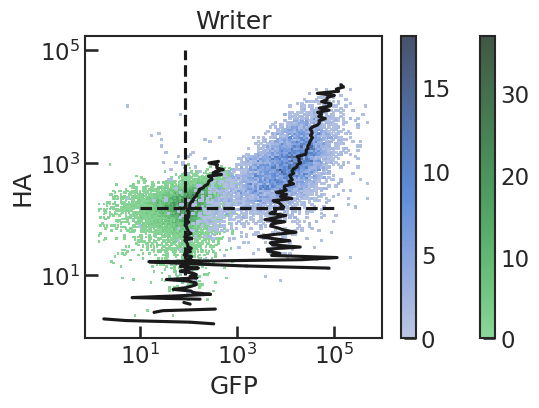

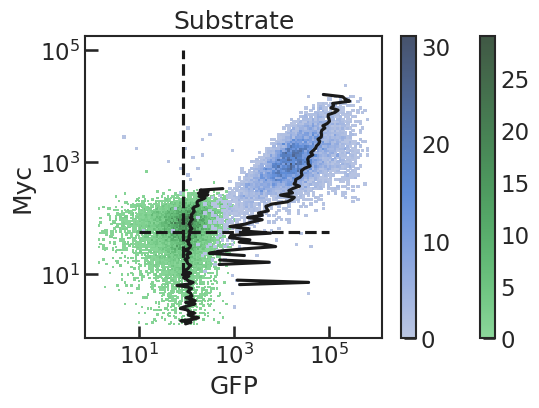

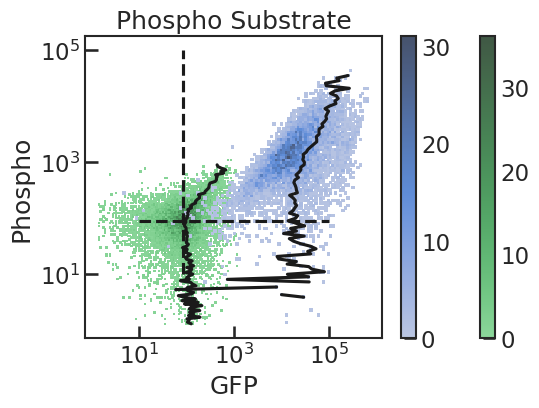

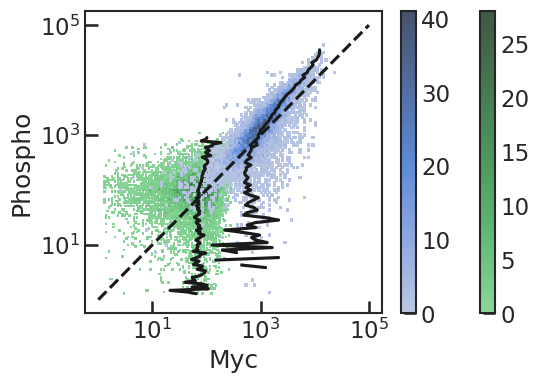

In [3]:
nbins_anti = 100
nbins_GFP = 100

writer_noise = noise.EmpiricalNoise("../data/noise_data/Flag noise.csv", 
                                   'HA', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)

empty_writer_noise = noise.EmpiricalNoise("../data/noise_data/Empty Cell.csv", 
                                   'HA', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_writer_noise.plot(ax, color='g')
writer_noise.plot(ax)

ax.set_title("Writer")

ax.hlines(10**np.mean(np.log10(empty_writer_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.vlines(10**np.mean(np.log10(empty_writer_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')


plt.show()

    
substrate_noise = noise.EmpiricalNoise("../data/noise_data/Phopho_Myc noise.csv", 
                                   'Myc', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)

empty_substrate_noise = noise.EmpiricalNoise("../data/noise_data/Empty Cell.csv", 
                                   'Myc', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)



fig, ax = plt.subplots(1, 1, figsize=(6, 4))
empty_substrate_noise.plot(ax, color='g')
substrate_noise.plot(ax)
ax.set_title("Substrate")

ax.hlines(10**np.mean(np.log10(empty_substrate_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_substrate_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()


    
phospho_noise = noise.EmpiricalNoise("../data/noise_data/Phopho_Myc noise.csv", 
                                   'Phospho', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)

empty_phospho_noise = noise.EmpiricalNoise("../data/noise_data/Empty Cell.csv", 
                                   'Phospho', 'GFP', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_GFP, 
                                   verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

empty_phospho_noise.plot(ax, color='g')
phospho_noise.plot(ax)
ax.set_title("Phospho Substrate")

ax.hlines(10**np.mean(np.log10(empty_phospho_noise.get_anti())), xmin=1e1, xmax=1e5, color='k', ls='--')
ax.vlines(10**np.mean(np.log10(empty_phospho_noise.get_GFP())), ymin=1e1, ymax=1e5, color='k', ls='--')

plt.show()



frac_noise = noise.EmpiricalNoise("../data/noise_data/Phopho_Myc noise.csv", 
                                   'Phospho', 'Myc', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_anti, 
                                   verbose=False)

emptry_frac_noise = noise.EmpiricalNoise("../data/noise_data/Empty Cell.csv", 
                                   'Phospho', 'Myc', 
                                   nbins_anti=nbins_anti, nbins_GFP=nbins_anti, 
                                   verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

emptry_frac_noise.plot(ax, color='g')
frac_noise.plot(ax)

t = np.linspace(1e0, 1e5)
ax.plot(t, t, 'k--')

plt.show()

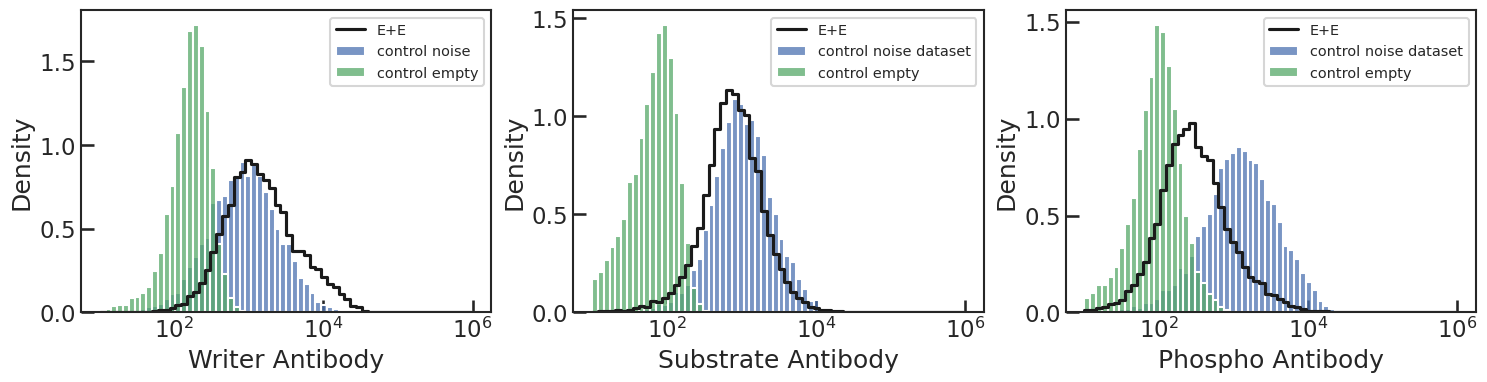

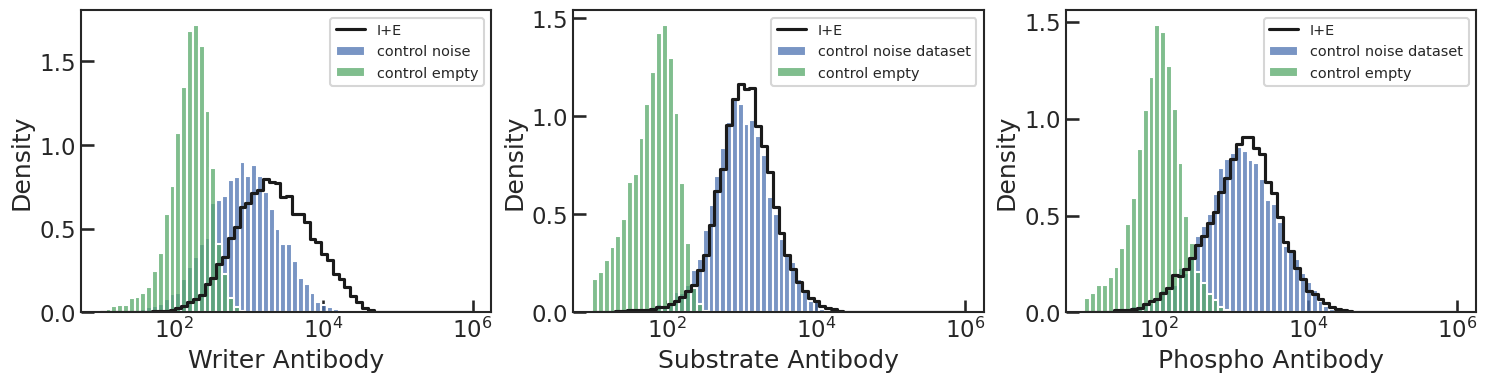

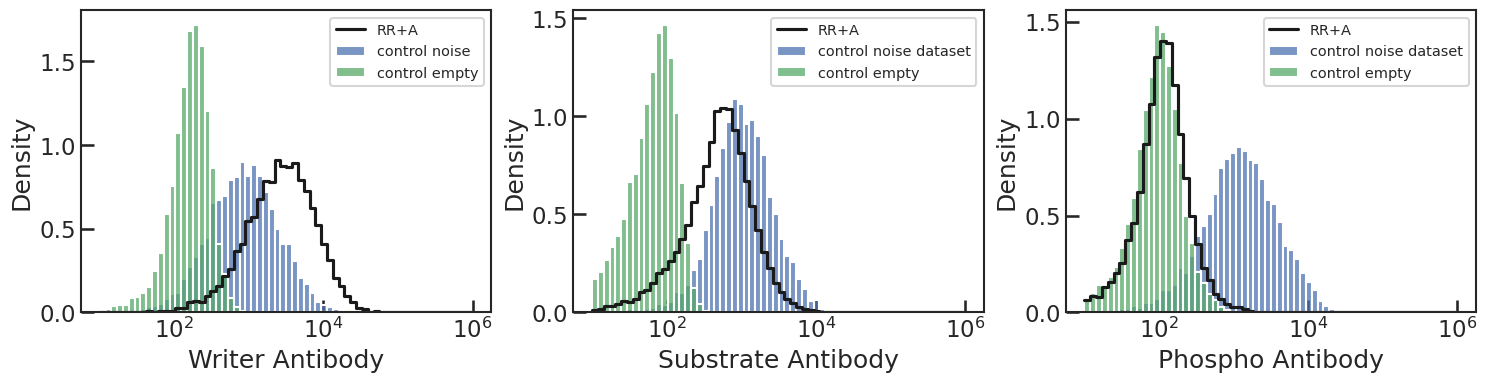

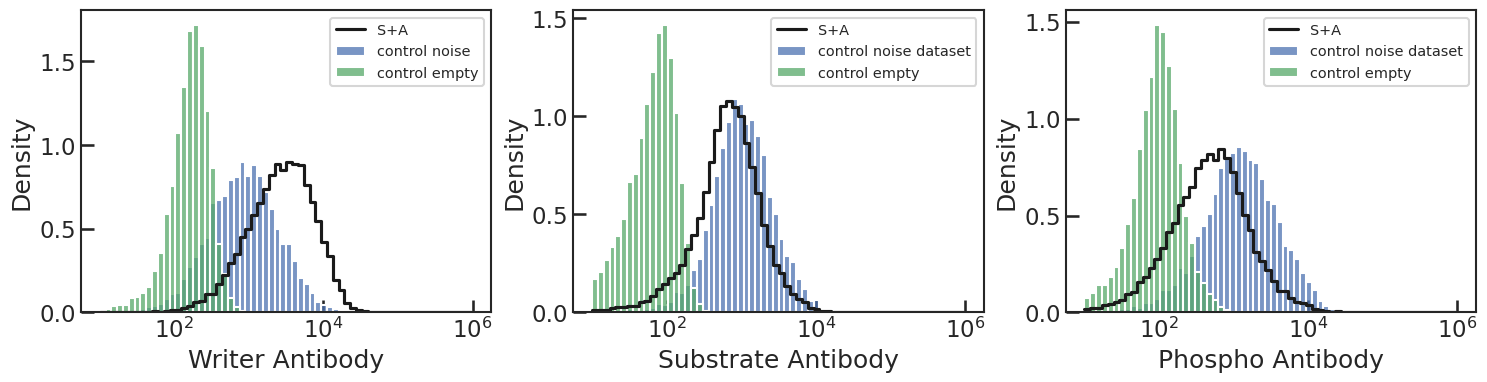

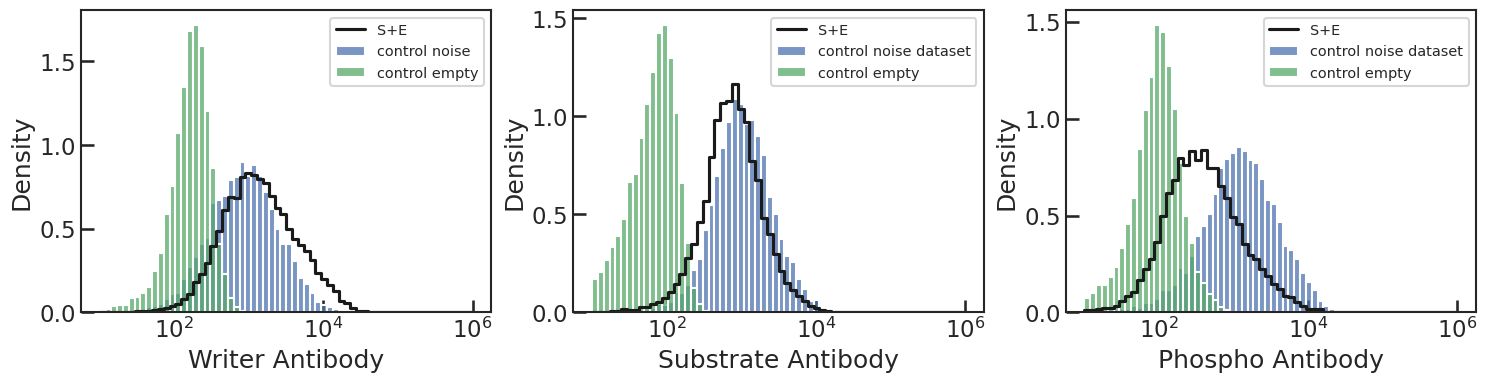

In [4]:

for dataset, group in df.groupby("dataset"):
    
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        
    ax = axes[0]
    
    sns.histplot(group['WT_anti_exp'], binrange=(1, 6), log_scale=True, bins=64, ax=ax, label=dataset, element='step', fill=False, color='k', stat='density')
    
    sns.histplot(writer_noise.get_anti(), binrange=(1, 6), log_scale=True, bins=64, ax=ax, label='control noise', color='b', stat='density')
    sns.histplot(empty_writer_noise.get_anti(), binrange=(1, 6), log_scale=True, bins=64, ax=ax, label='control empty', color='g', stat='density')
        
    ax.set_xlabel("Writer Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
            
        
    ax = axes[1]
        
    sns.histplot(group['ST_anti_exp'], binrange=(1, 6), log_scale=True, bins=64, ax=ax, label=dataset, element='step', fill=False, color='k', stat='density')
    
    sns.histplot(substrate_noise.get_anti(), binrange=(1, 6), log_scale=True, bins=64, ax=ax, label='control noise dataset', color='b', stat='density')
    sns.histplot(empty_substrate_noise.get_anti(), binrange=(1, 6), log_scale=True, bins=64, ax=ax, label='control empty', color='g', stat='density')

    ax.set_xlabel("Substrate Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
    
    ax = axes[2]
    
    sns.histplot(group['SpT_anti_exp'], binrange=(1, 6), log_scale=True, bins=64, ax=ax, label=dataset, element='step', fill=False, color='k', stat='density')
    
    sns.histplot(phospho_noise.get_anti(), binrange=(1, 6), log_scale=True, bins=64, ax=ax, label='control noise dataset', color='b', stat='density')
    sns.histplot(empty_phospho_noise.get_anti(), binrange=(1, 6), log_scale=True, bins=64, ax=ax, label='control empty', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
    plt.show()
    
    



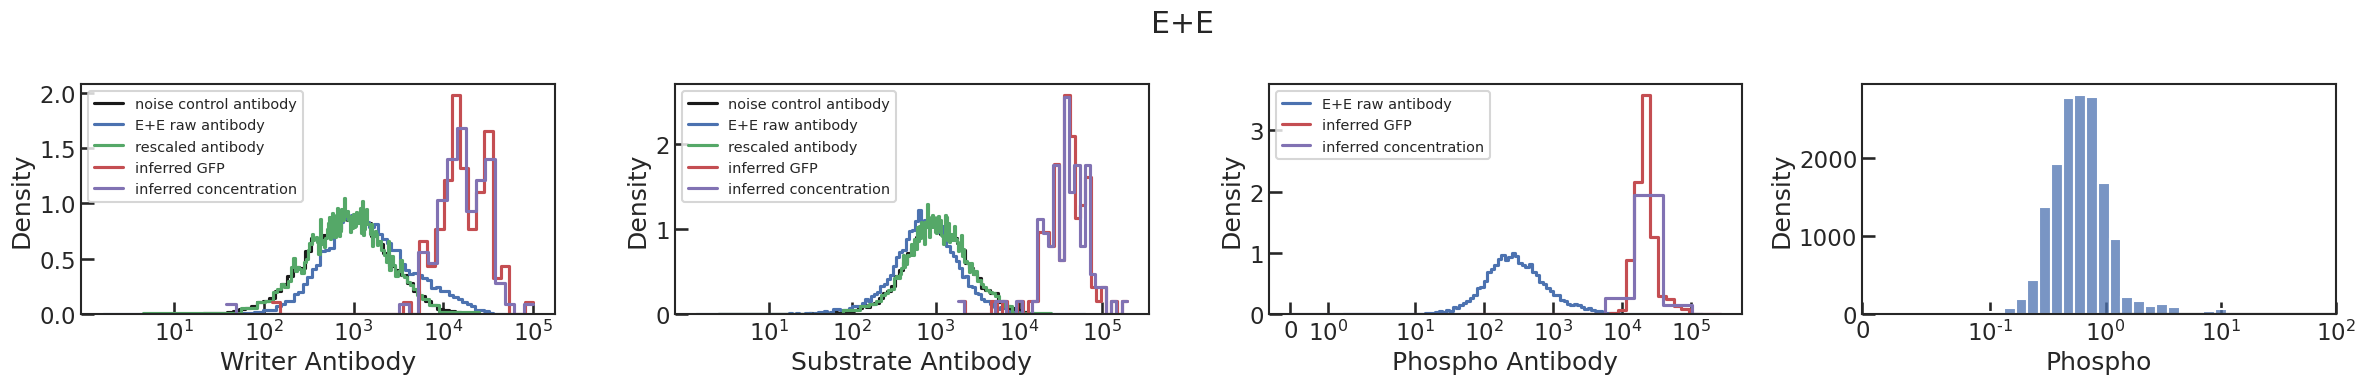

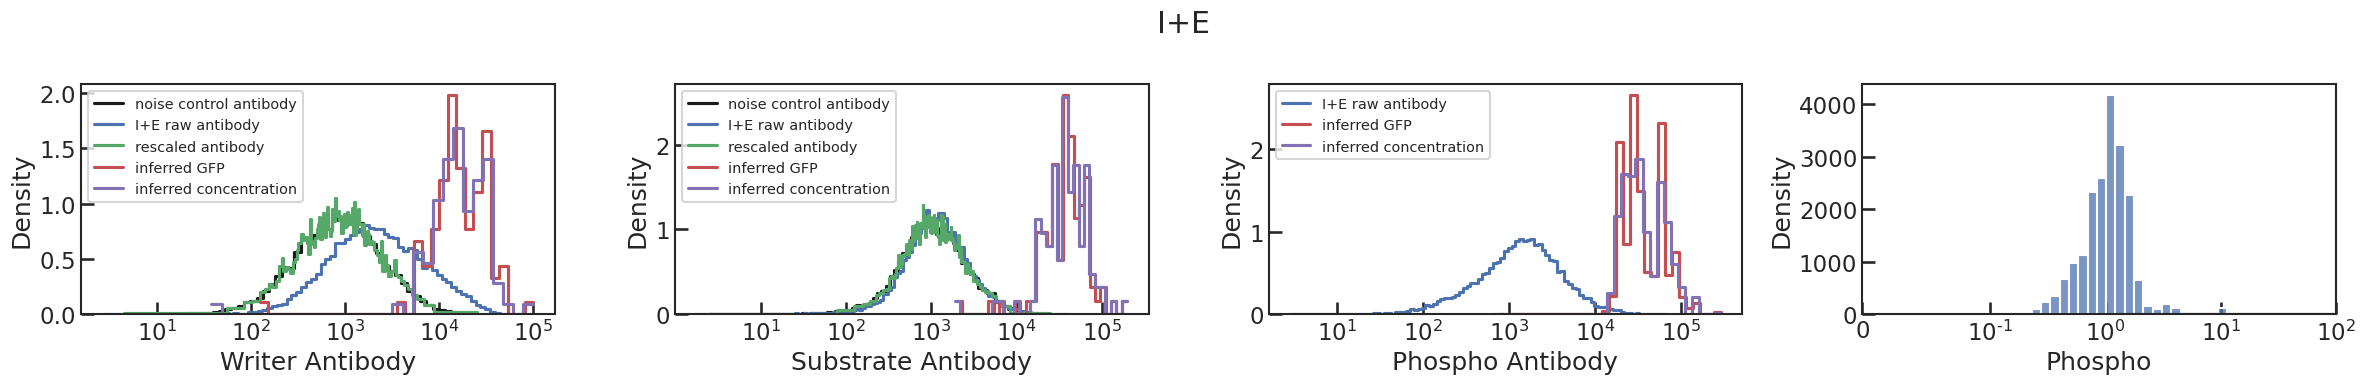

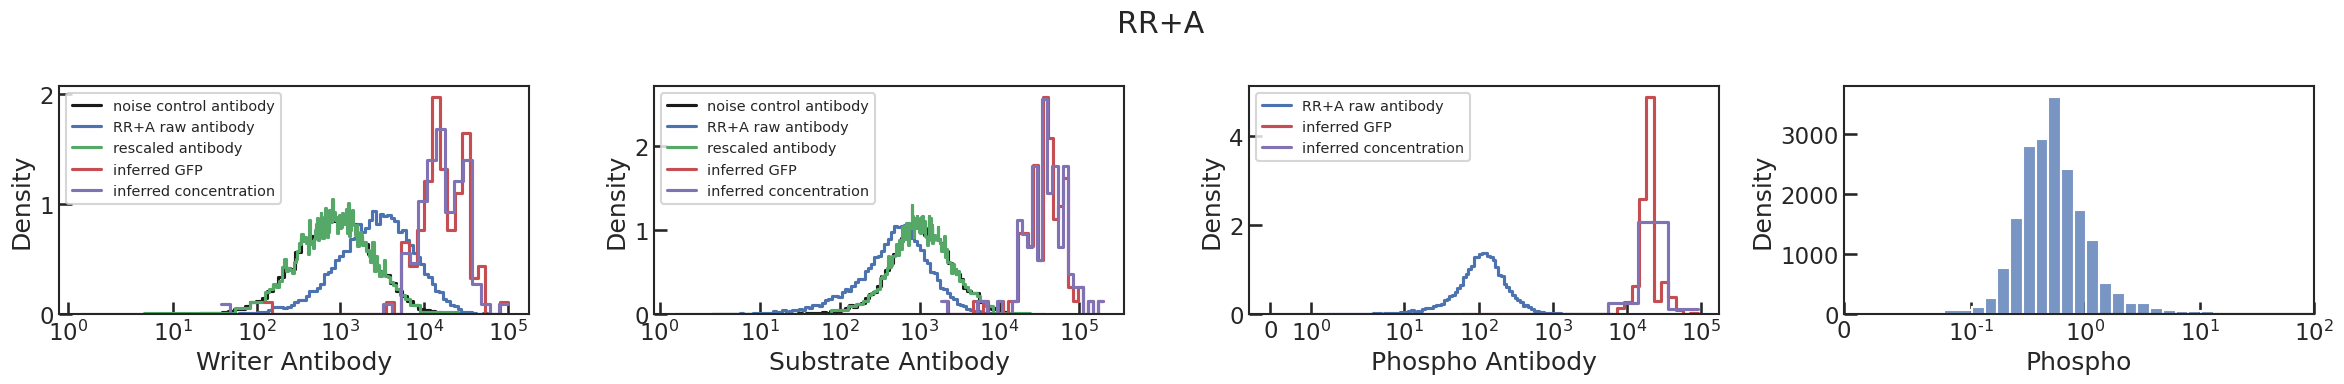

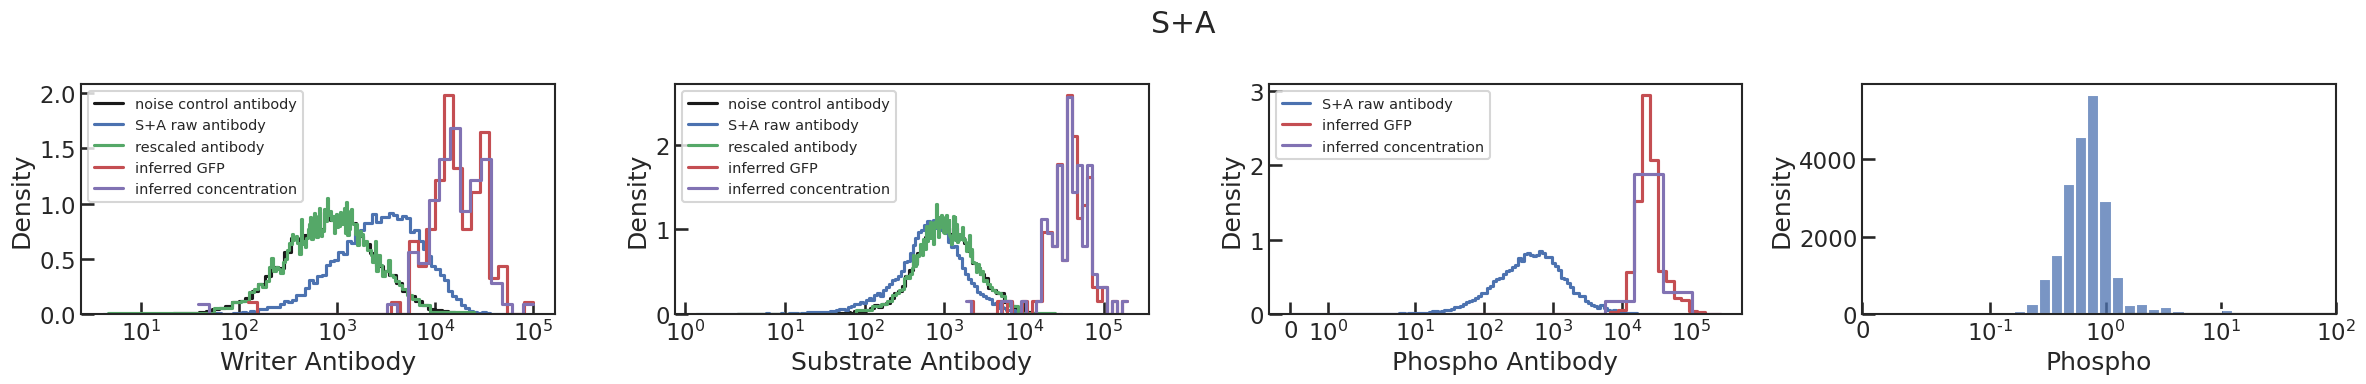

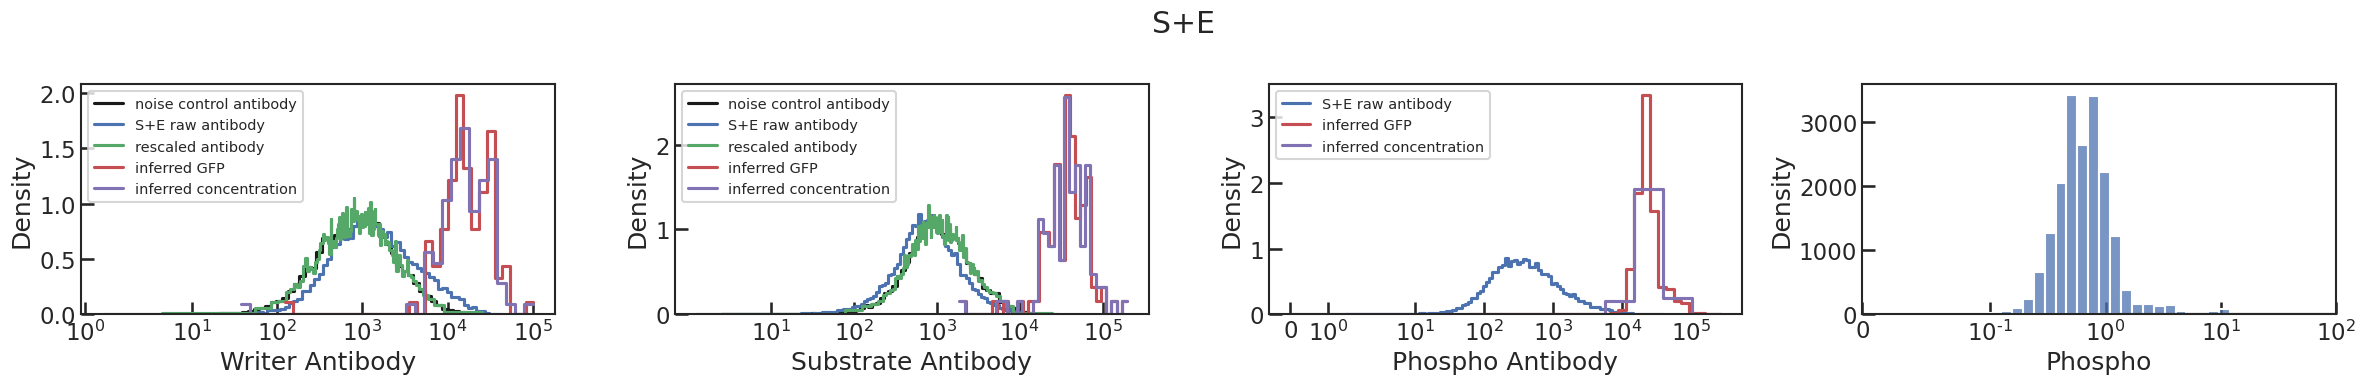

WT_anti_exp  ST_anti_exp  SpT_anti_exp  Sp_frac_anti_exp  \
dataset                                                                    
E+E     0       5993.989258  6394.181152   8649.121094          1.352655   
        1        484.283875   664.000793    564.378601          0.849967   
        2        605.894165   737.394714     91.147232          0.123607   
        3        803.416565   333.886597    168.033020          0.503264   
        4       3100.157715   131.973206     60.481567          0.458287   
...                     ...          ...           ...               ...   
S+E     18757   1177.671265   390.252075    400.376099          1.025942   
        18758   1190.564575    81.183945    158.838196          1.956522   
        18759  11397.416992  1473.975220    342.042755          0.232055   
        18760   1293.171875   652.249451    481.467163          0.738164   
        18761    322.256653   336.612762     55.410645          0.164612   

               WT_anti_rescaled  WT_GFP_infer       WT_conc  ST_anti_rescaled  \
dataset                                                                         
E+E     0           2997.435979  32504.352840  32418.534071       7427.901542   
        1            285.524453   6467.721522   6381.902754        888.537599   
        2            359.450271   9356.282411   9270.463643        965.054228   
        3            507.512389  13732.438391  13646.619623        427.880678   
        4           1792.006051  28765.051597  28679.232829        175.759980   
...                         ...           ...           ...               ...   
S+E     18757        796.471905  14322.789327  14236.970558        508.455458   
        18758        796.471905  14322.789327  14236.970558         98.622699   
        18759       5473.162423  48774.506743  48688.687975       2060.959595   
        18760        858.288810  17117.109434  17031.290666        870.493405   
        18761        205.788377   5544.539916   5458.721148        445.324019   

                ST_GFP_infer        ST_conc  SpT_GFP_infer      SpT_conc  \
dataset                                                                    
E+E     0      135823.950743  135738.131975   83710.041268  83624.222500   
        1       40791.003691   40705.184923   20486.480322  20400.661553   
        2       36864.907515   36779.088747   13992.943345  13907.124577   
        3       20084.699213   19998.880445   21048.997877  20963.179108   
        4        6318.581494    6232.762725   20965.149439  20879.330671   
...                      ...            ...            ...           ...   
S+E     18757   20169.905612   20084.086844   19647.343333  19561.524564   
        18758    1962.228640    1876.409872   21048.997877  20963.179108   
        18759   61695.918602   61610.099834   20549.233533  20463.414765   
        18760   40791.003691   40705.184923   19374.087173  19288.268405   
        18761   20084.699213   19998.880445   11231.909557  11146.090788   

               Sp_frac_conc  
dataset                      
E+E     0          0.616070  
        1          0.501181  
        2          0.378126  
        3          1.048218  
        4          3.349932  
...                     ...  
S+E     18757      0.973981  
        18758     11.171962  
        18759      0.332144  
        18760      0.473853  
        18761      0.557336  

[96261 rows x 13 columns]

In [5]:

nbins = 100
zero = 1e-8

for dataset, group in df.groupby("dataset"):
    
    
    fig, axes = plt.subplots(1, 4, figsize=(24, 4))
    
    fig.suptitle(dataset)
    
    # calculate quantile bins of antibody noise measurements
      
    _ , writer_bins = pd.qcut(writer_noise.get_anti(), nbins, labels=False, retbins=True)
       
    # calculate average value in each bin
    bin_avg = np.sqrt(writer_bins[1:]*writer_bins[:len(writer_bins)-1])
    
    # calculate quantile of antibody measurements in actual dataset
    q = pd.qcut(group['WT_anti_exp'], nbins, labels=False).values
    
    # map quantiles of dataset to average measurements in quantiles in noise dataset
    df.loc[group.index, 'WT_anti_rescaled'] = bin_avg[q]
        
    # convert antibody measurements average GFP measurements from noise data
    df.loc[group.index, 'WT_GFP_infer'] = writer_noise.anti_to_GFP_avg(df.loc[group.index, 'WT_anti_rescaled'])
    
    # subtract mean of noise measurements to approximate "concentration" measurements
    df.loc[group.index, 'WT_conc'] = np.maximum(df.loc[group.index, 'WT_GFP_infer'] - 10**np.mean(np.log10(empty_writer_noise.get_GFP())), zero)

    ax = axes[0]

    sns.histplot(writer_noise.get_anti(), log_scale=True, ax=ax, label='noise control antibody', element='step', 
                 fill=False, color='k', stat='density')
                       
    sns.histplot(group['WT_anti_exp'], log_scale=True, ax=ax, label=dataset + " raw antibody", element='step', 
                      fill=False, color='b', stat='density')
    
    sns.histplot(df.loc[group.index, 'WT_anti_rescaled'], bins=np.log10(writer_bins), ax=ax, log_scale=True, 
                 color='g', fill=False, element="step", stat='density', label='rescaled antibody')
    
    sns.histplot(df.loc[group.index, 'WT_GFP_infer'], log_scale=True, ax=ax, label='inferred GFP', element='step', 
                 fill=False, color='r', stat='density', bins=32)
    
    sns.histplot(df.loc[group.index, 'WT_conc'], log_scale=True, ax=ax, label='inferred concentration', element='step', 
                 fill=False, color='m', stat='density', bins=32)
    
    ax.set_xlabel("Writer Antibody")

    ax.legend(loc='upper left', fontsize='xx-small')
    ax.set_xscale('symlog')
                
    
    
      
    _ , substrate_bins = pd.qcut(substrate_noise.get_anti(), nbins, labels=False, retbins=True)
    
    bin_avg = np.sqrt(substrate_bins[1:]*substrate_bins[:len(substrate_bins)-1])
    
    q = pd.qcut(group['ST_anti_exp'], nbins, labels=False).values
    
    df.loc[group.index, 'ST_anti_rescaled'] = bin_avg[q]
        
    df.loc[group.index, 'ST_GFP_infer'] = substrate_noise.anti_to_GFP_avg(df.loc[group.index, 'ST_anti_rescaled'])
    
    df.loc[group.index, 'ST_conc'] = np.maximum(df.loc[group.index, 'ST_GFP_infer'] - 10**np.mean(np.log10(empty_substrate_noise.get_GFP())), zero)

    ax = axes[1]
    
    sns.histplot(substrate_noise.get_anti(), log_scale=True, ax=ax, label='noise control antibody', element='step', 
                 fill=False, color='k', stat='density')
                       
    sns.histplot(group['ST_anti_exp'], log_scale=True, ax=ax, label=dataset + " raw antibody", element='step', 
                      fill=False, color='b', stat='density')
    
    sns.histplot(df.loc[group.index, 'ST_anti_rescaled'], bins=np.log10(substrate_bins), ax=ax, log_scale=True, 
                 color='g', fill=False, element="step", stat='density', label='rescaled antibody')
    
    sns.histplot(df.loc[group.index, 'ST_GFP_infer'], log_scale=True, ax=ax, label='inferred GFP', element='step', 
                 fill=False, color='r', stat='density', bins=32)
    
    sns.histplot(df.loc[group.index, 'ST_conc'], log_scale=True, ax=ax, label='inferred concentration', element='step', 
                 fill=False, color='m', stat='density', bins=32)
    
    ax.set_xlabel("Substrate Antibody")

    ax.legend(loc='upper left', fontsize='xx-small')
    ax.set_xscale('symlog')
    
    
    
    df.loc[group.index, 'SpT_GFP_infer'] = phospho_noise.anti_to_GFP_avg(df.loc[group.index, 'SpT_anti_exp'])
    
    df.loc[group.index, 'SpT_conc'] = np.maximum(df.loc[group.index, 'SpT_GFP_infer'] - 10**np.mean(np.log10(empty_phospho_noise.get_GFP())), zero)
    
    ax = axes[2]
    
    sns.histplot(phospho_noise.get_anti(), log_scale=True, bins=nbins,
                      label='noise control antibody', element='step', fill=False, color='k', stat='density')

    sns.histplot(group['SpT_anti_exp'], log_scale=True, ax=ax, bins=nbins, 
                 label=dataset + " raw antibody", element='step', fill=False, color='b', stat='density')
    
    sns.histplot(df.loc[group.index, 'SpT_GFP_infer'], log_scale=True, ax=ax, label='inferred GFP', element='step', 
                 fill=False, color='r', stat='density', bins=32)
    
    sns.histplot(df.loc[group.index, 'SpT_conc'], log_scale=True, ax=ax, label='inferred concentration', element='step', 
                 fill=False, color='m', stat='density', bins=32)
        
    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper left', fontsize='xx-small')
        
    ax.set_xscale('symlog')
    

        
    df.loc[group.index, 'Sp_frac_conc'] = df.loc[group.index, 'SpT_conc'] / df.loc[group.index, 'ST_conc']
    
    ax = axes[3]
    
    sns.histplot(df.query('dataset==@dataset and SpT_conc > @zero')['Sp_frac_conc'], log_scale=True, ax=ax, bins=32)
    
    ax.set_xscale('symlog',linthresh=1e-1)
    
    ax.set_xlim(0.0, 1e2)
    
    
    plt.tight_layout()
    
    plt.show()

display(df)

# df = df.query("SpT_conc <= ST_conc").copy()

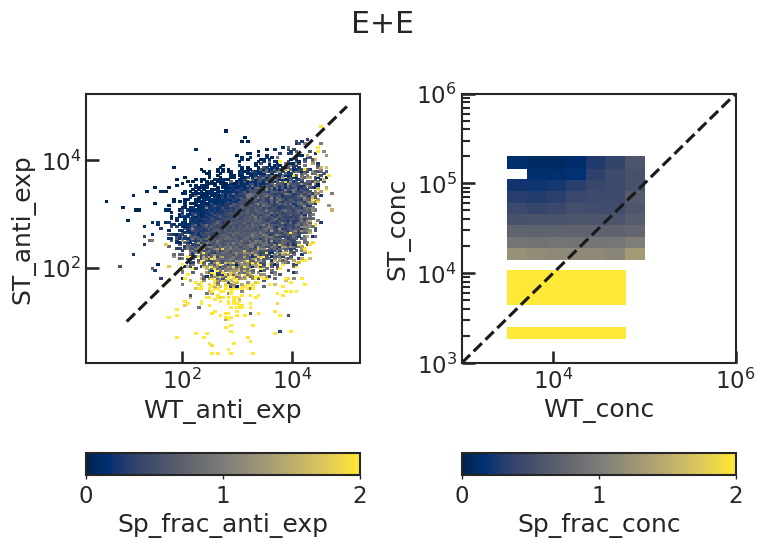

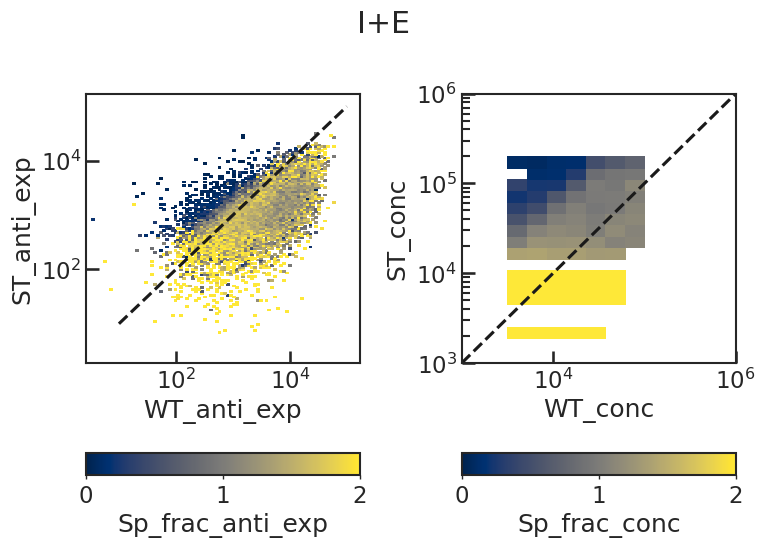

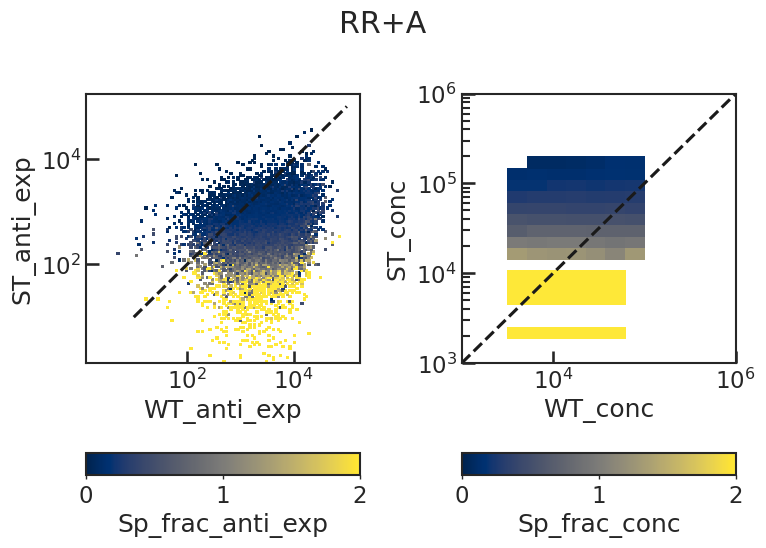

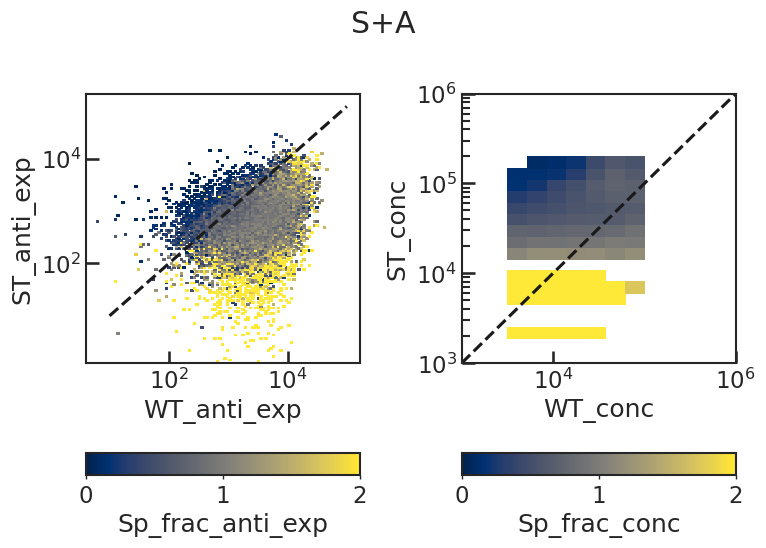

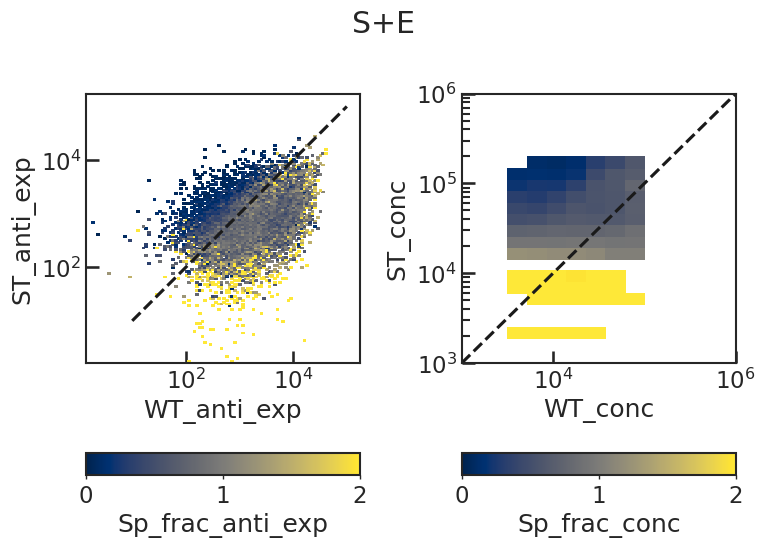

In [6]:



for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4.5))
    
    ax = axes[0]
    
    df_tmp = group.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_exp']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_exp']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_exp'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_exp'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_exp'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm1 = mpl.colors.Normalize(vmin=0, vmax=2.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm1, rasterized=True)
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_exp')
    ax.set_ylabel('ST_anti_exp')
    
    
    ax = axes[1]
    
    df_tmp = group.copy().dropna()
        
    hist, xedges = np.histogram(np.log10(df_tmp['WT_conc']), bins=16)
    hist, yedges = np.histogram(np.log10(df_tmp['ST_conc']), bins=16)
    xedges = 10**xedges
    yedges = 10**yedges

#     xedges = writer_bins
#     yedges = substrate_bins

    df_tmp['xbin'] = pd.cut(df_tmp['WT_conc'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_conc'], yedges, labels=False)
    

    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_conc'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm2 = mpl.colors.Normalize(vmin=0, vmax=2.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm2, rasterized=True)
    
    t = np.linspace(1e3, 1e6)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc')
    ax.set_ylabel('ST_conc')
    
    ax.set_xlim(1e3, 1e6)
    ax.set_ylim(1e3, 1e6)
        
    fig.suptitle(construct)
    
    
    plt.tight_layout()
    
    
    
    bbox = axes[0].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm1, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_exp")
    
    
    bbox = axes[1].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm2, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_conc")
    
    

    plt.show()
    

In [7]:
def solve(df, df_info, param_dict, x0, bounds, verbose=False):

    if verbose:
        start = time.time()

    def func(x):
                        
        loss = 0.0
        
        for index, row in df_info.iterrows():
            dataset = row['dataset']
            
            construct = row['construct']
            
            
#             noise_params = np.array(x)[param_dict[construct][0:1]]
            model_params = 10**np.array(x)[param_dict[construct][0:]]
                
#             df_data = df.query("dataset=='{}'".format(dataset)).dropna()
            df_data = df.query("dataset=='{}'".format(dataset))
            
#             phospho_scale = noise_params[0]

            
            # predict inferred antibody values for phosphorylated substrate
#             if row['model'] == 'background':
                 
#                 df.loc[df_data.index, 'SpT_anti_infer'] = pp.Background().predict_all(df_data[['ST_anti_rescaled']].values, model_params)
            
            if row['model'] == 'push':
                            
#                 df.loc[df_data.index, 'SpT_anti_infer'] = pp.PushAmp().predict_all(df_data[['WT_anti_rescaled', 'ST_anti_rescaled']].values, model_params)
            
                df.loc[df_data.index, 'SpT_conc_predict'] = pp.PushAmp().predict_all(df_data[['WT_conc', 'ST_conc']].values, model_params)[:, 0]
            
#                 print(df.loc[df_data.index, 'SpT_conc_predict'])
                       

#             df.loc[df_data.index, 'Sp_frac_predict'] = df.loc[df_data.index, 'SpT_predict'] / df.loc[df_data.index, 'ST_conc']
            
#             loss += np.mean((df.loc[df_data.index, 'Sp_frac_predict']-df.loc[df_data.index, 'Sp_frac_conc'])**2)

            df.loc[df_data.index, 'SpT_GFP_predict'] = df.loc[df_data.index, 'SpT_conc_predict'] + 10**np.mean(np.log10(empty_phospho_noise.get_GFP()))
            
            loss += np.mean((np.log10(df.loc[df_data.index, 'SpT_GFP_predict'])-np.log10(df.loc[df_data.index, 'SpT_GFP_infer']))**2)
            
            
        return loss




    print("Initial Loss:", func(x0))

    def callback(x):
        print(func(x), x)

    res = opt.minimize(func, x0, method='L-BFGS-B', 
                       jac='2-point', bounds=bounds, 
                       options={'iprint':101, 'eps': 1e-8, 
                                'gtol': 1e-8, 'ftol':1e-12,
                               'finite_diff_rel_step': 1e-2},
                      callback=callback)
    

#     callback = lambda x, f, context: print(f, x, context)
    
#     seed = 43
#     rand.seed(seed)
#     res = opt.dual_annealing(func, bounds, x0=x0, seed=seed, no_local_search=False, callback=callback, maxiter=100)


    print("Final Loss:", res.fun, func(res.x))

    end = time.time()

    print("Time Elapsed", end-start, "seconds")

    print(res)
        
    
    return res

In [8]:
param_dict = {}

param_labels = [r"$\log_{10}(v_{bg}^p)$", r"$\log_{10}(v_{WS}^p)$"]
x0 = [-1.0, 1.5]
bounds = [(None, None), (None, None)]
# bounds = [(-3, 1), (-3, 3)]

param_index = 1
for index, row in df_info.iterrows():
    
    construct = row['construct']
    model = row['model']
                
    if construct not in param_dict:
        if model == 'background':
            param_dict[construct] = [0]

        elif model == 'push':
            param_dict[construct] = [0, 1, param_index+1]
            param_index += 1
            
            param_labels.append(construct + ": " + r"$\log_{10}(\alpha_{WS})$")
            x0.append(4.0)
            bounds.append((None, None))
        

print(param_labels)
print(param_dict)

print(x0)
print(bounds)

res = solve(df, df_info, param_dict, x0, bounds, verbose=True)


['$\\log_{10}(v_{bg}^p)$', '$\\log_{10}(v_{WS}^p)$', 'E+E: $\\log_{10}(\\alpha_{WS})$', 'I+E: $\\log_{10}(\\alpha_{WS})$', 'RR+A: $\\log_{10}(\\alpha_{WS})$', 'S+A: $\\log_{10}(\\alpha_{WS})$', 'S+E: $\\log_{10}(\\alpha_{WS})$']
{'E+E': [0, 1, 2], 'I+E': [0, 1, 3], 'RR+A': [0, 1, 4], 'S+A': [0, 1, 5], 'S+E': [0, 1, 6]}
[-1.0, 1.5, 4.0, 4.0, 4.0, 4.0, 4.0]
[(None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None)]
Initial Loss: 0.47550543564717723
0.38098196030810144 [-0.76097706  0.80915016  4.0275168   3.9652577   4.04044205  4.01657898
  4.01940052]
0.3680637619466204 [-0.48114809  0.73869877  4.02264396  3.80941184  4.06912453  3.98091532
  3.99190053]
0.36599906527933335 [-0.17266167  0.7898318   3.9879155   3.52478639  4.12244085  3.87596178
  3.90339688]
0.361626601924664 [-0.21117942  0.68039263  3.99072152  3.50315727  4.13423438  3.8719803
  3.90108289]
0.36057073358997316 [-0.26753262  0.67929856  3.98542544  3.47348226  4.14292828  3.8

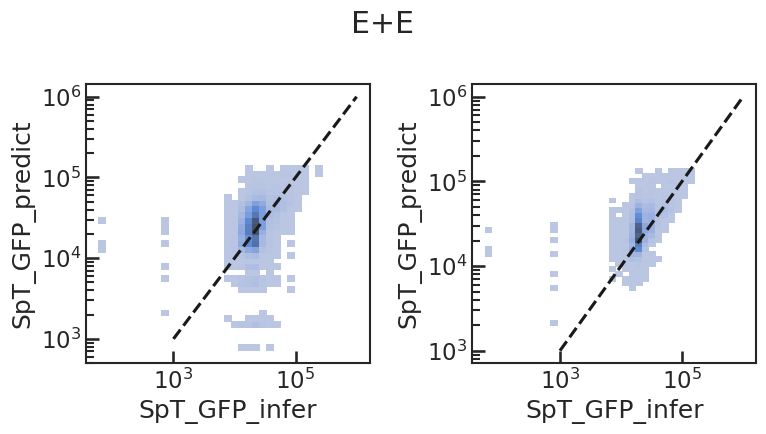

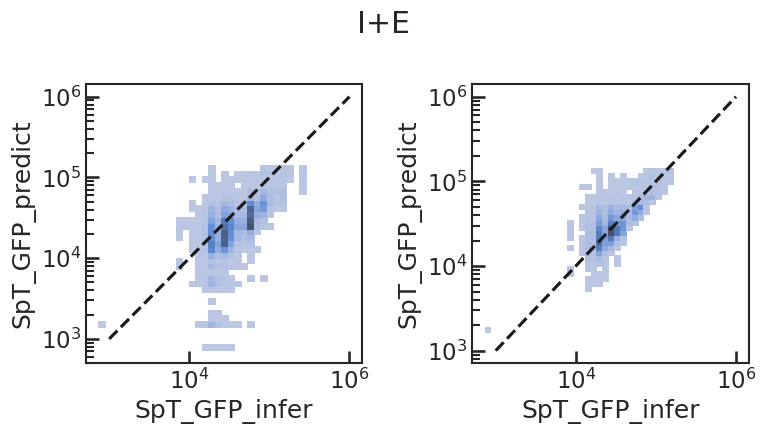

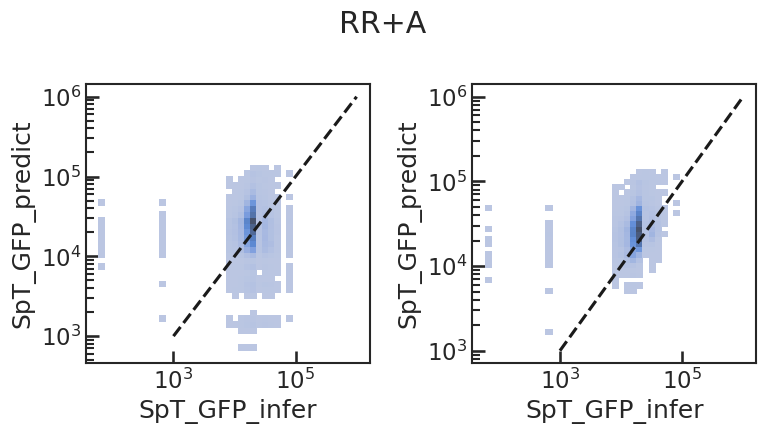

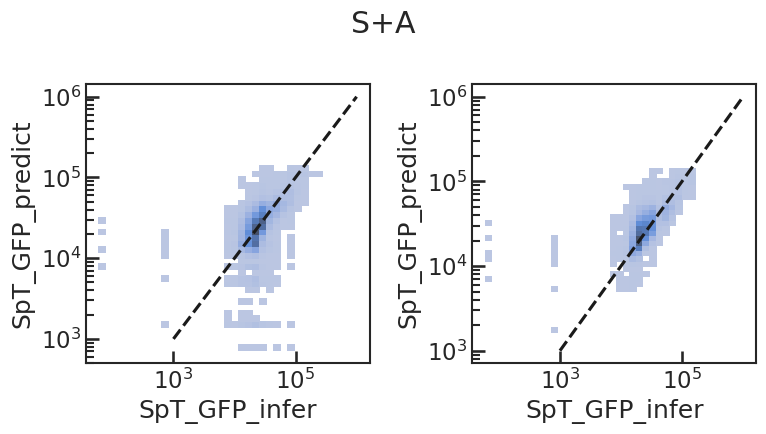

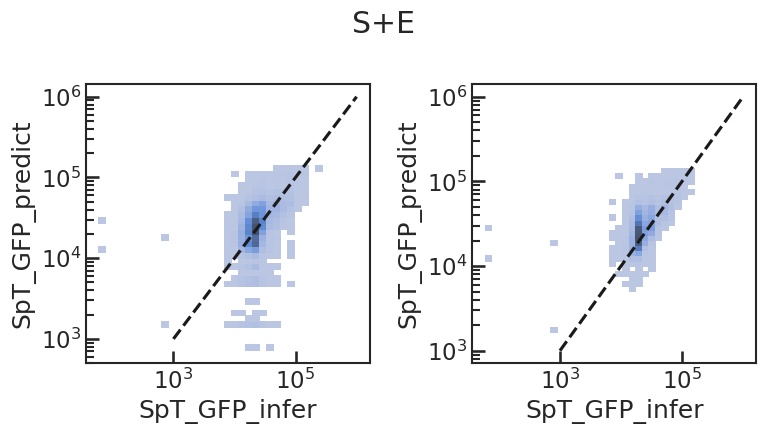

In [9]:



for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4.5))
    
    fig.suptitle(construct)
    
    ax = axes[0]
    
    sns.histplot(group, x='SpT_GFP_infer', y='SpT_GFP_predict', 
                 log_scale=(True, True), ax=ax, bins=32)
        
    
    t = np.logspace(3, 6, 100)
    ax.plot(t, t, 'k--')
    
    
    ax = axes[1]
    
    sns.histplot(group.query("SpT_conc <= ST_conc"), x='SpT_GFP_infer', y='SpT_GFP_predict', 
                 log_scale=(True, True), ax=ax, bins=32)
        
    
    t = np.logspace(3, 6, 100)
    ax.plot(t, t, 'k--')
    
    plt.tight_layout()
    
    

    plt.show()
    

[0.42090514 4.08906874 4.07396944]


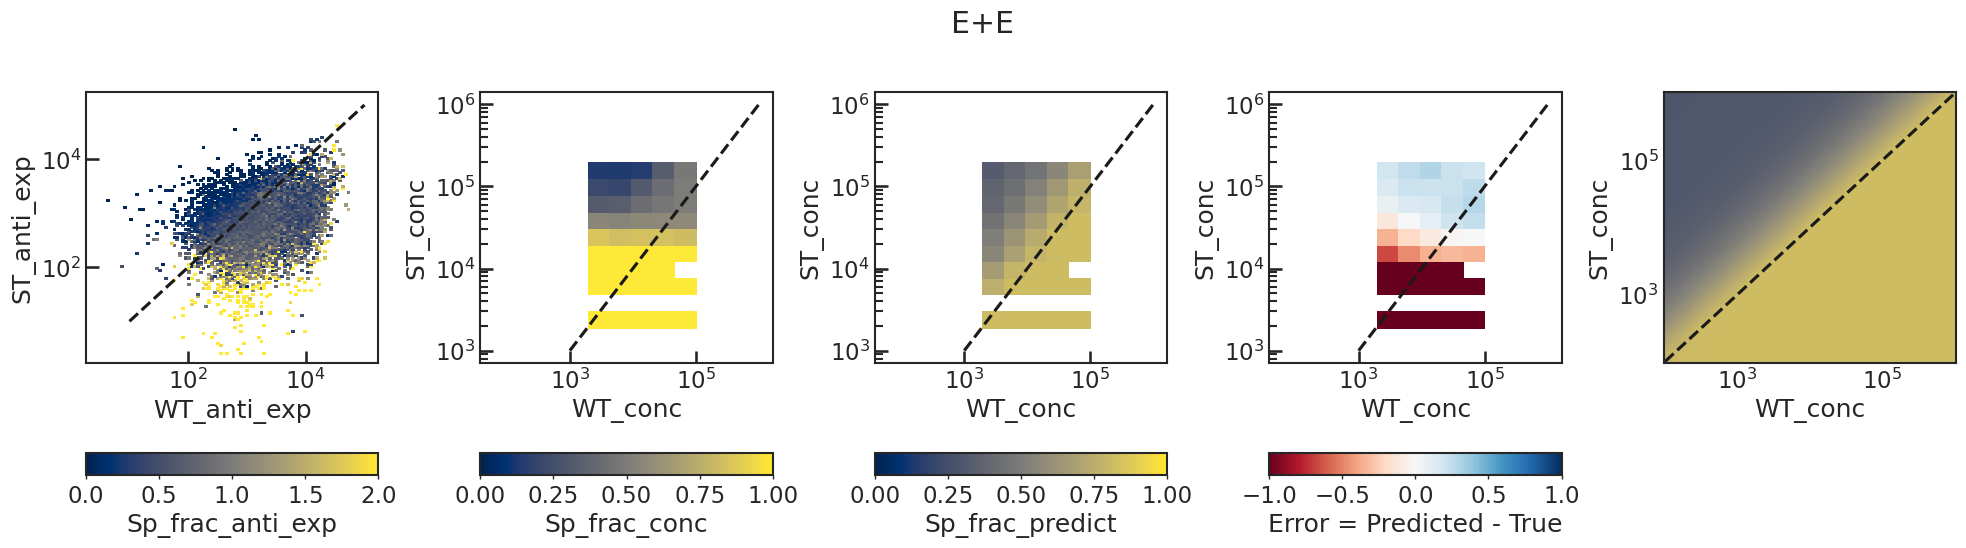

[4.20905144e-01 4.08906874e+00 3.23615369e-06]


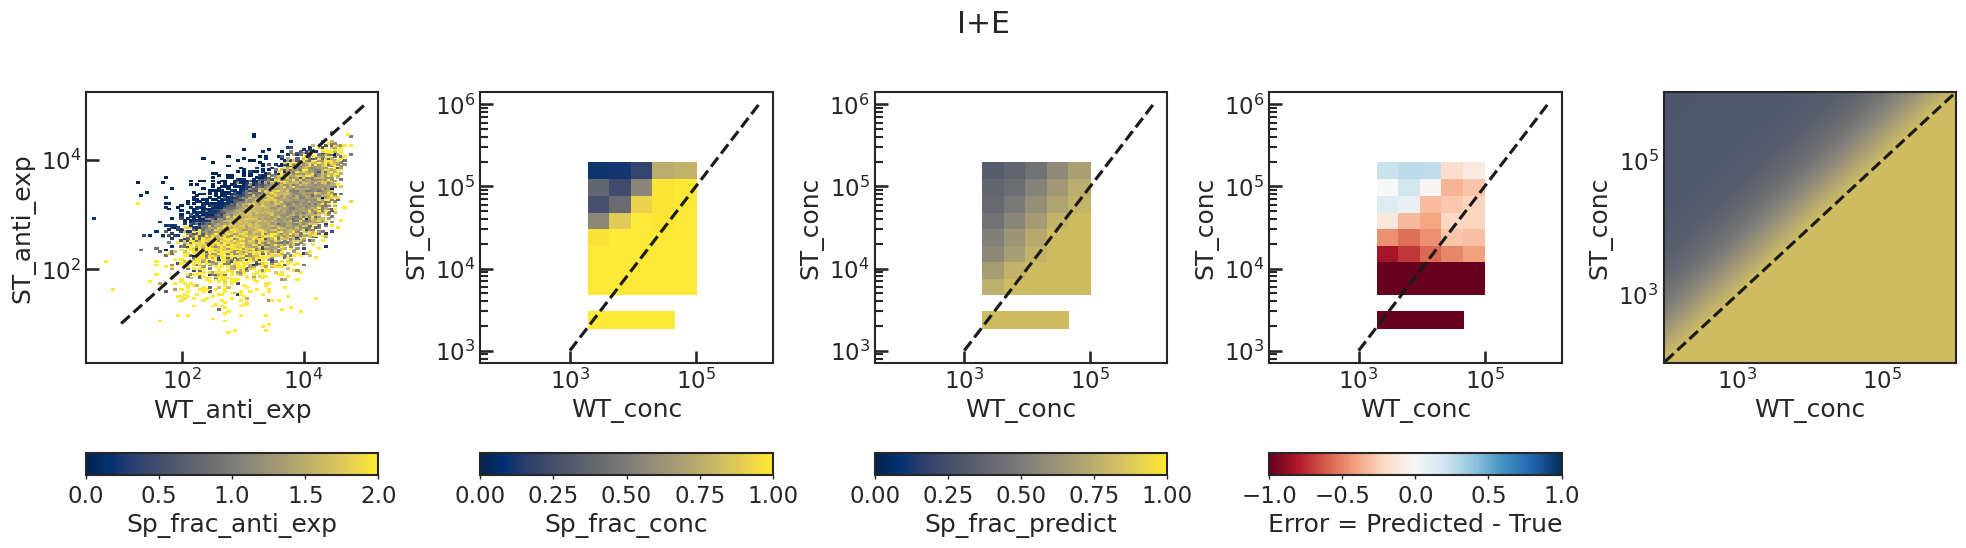

[4.20905144e-01 4.08906874e+00 7.33130603e+03]


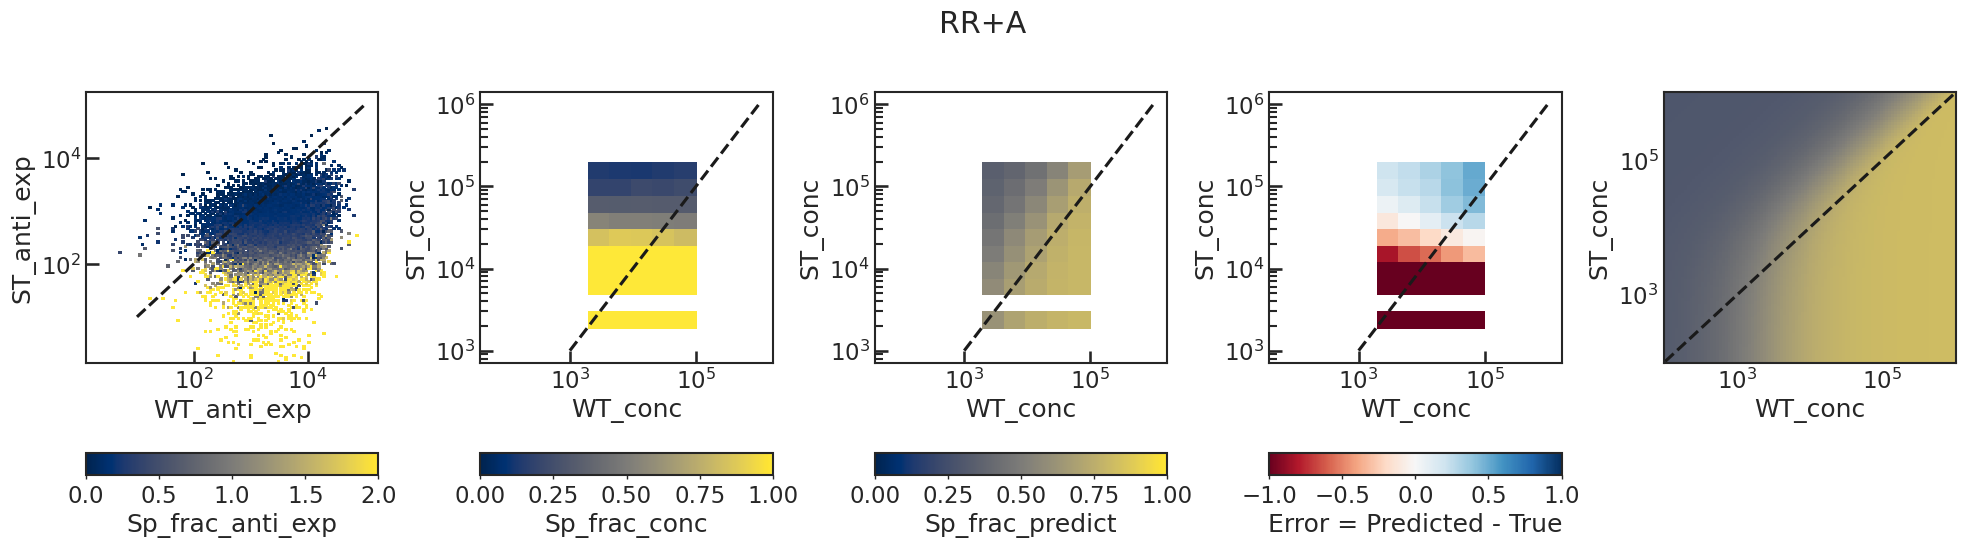

[0.42090514 4.08906874 0.07888482]


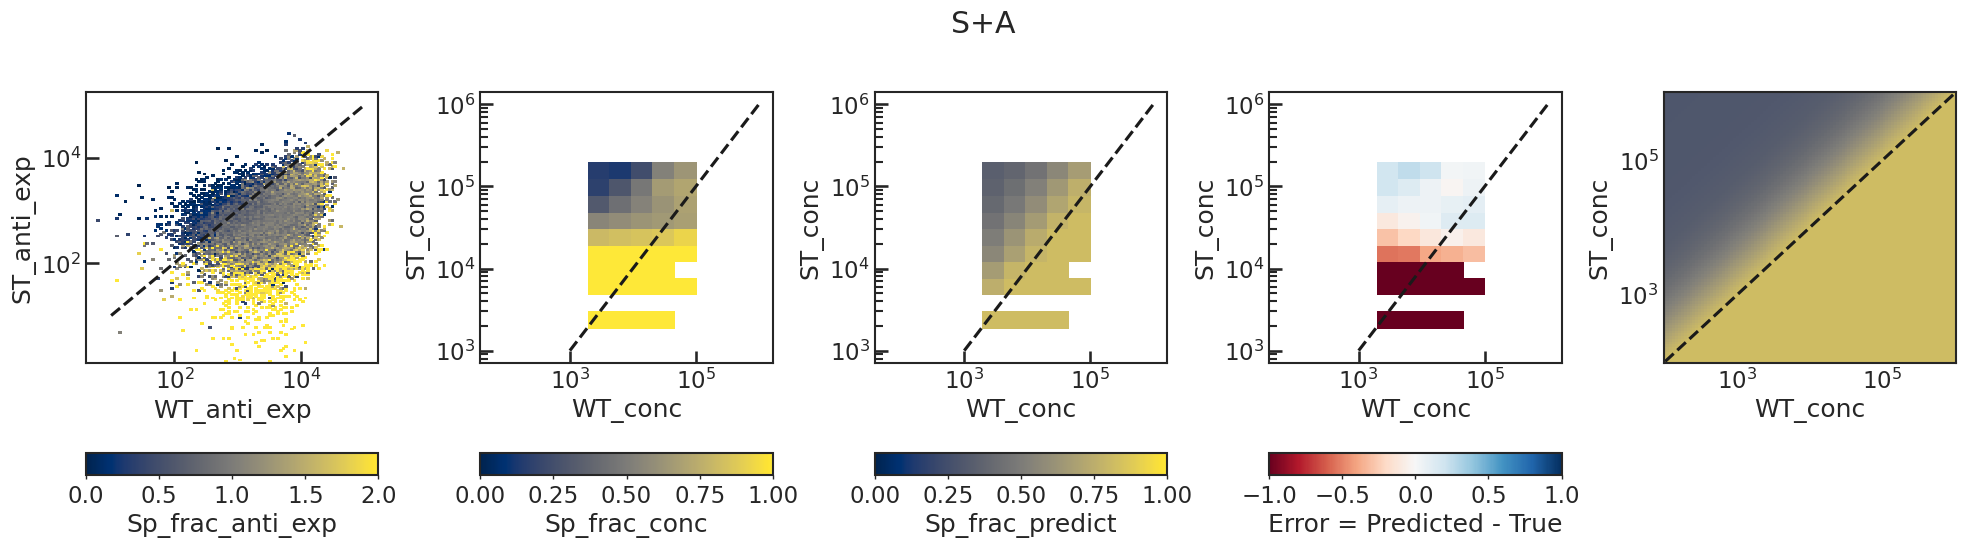

[0.42090514 4.08906874 0.18877464]


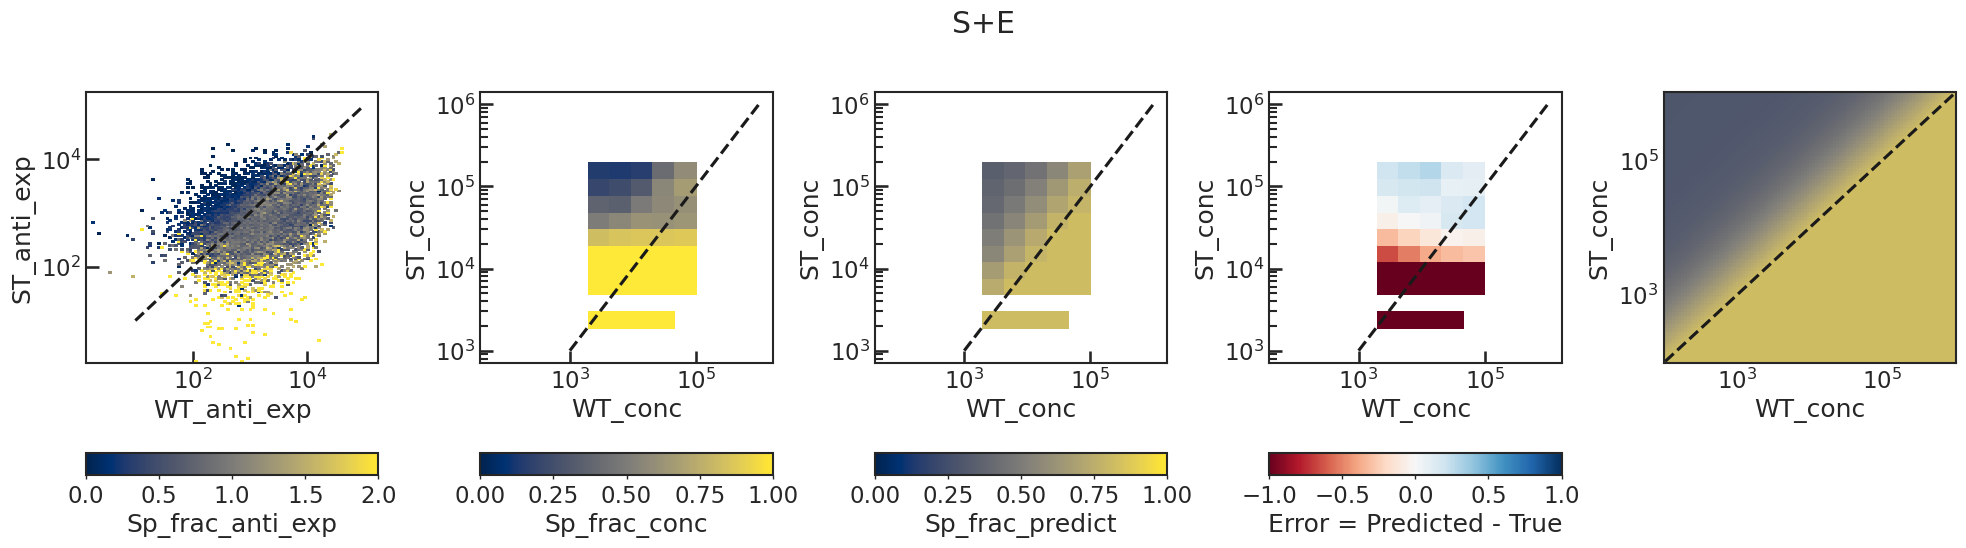

In [13]:



for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    
#     noise_params = res.x[param_dict[construct][0:1]]
    model_params = 10**res.x[param_dict[construct][0:]]
    print(model_params)

    
#     phospho_scale = noise_params[0]

    phospho_scale = 1.0
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4.5))
    
    fig.suptitle(construct)
    
    ax = axes[0]
    
    df_tmp = group.copy()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_anti_exp']), bins='auto')
    hist, yedges = np.histogram(np.log10(df_tmp['ST_anti_exp']), bins='auto')
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_anti_exp'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_anti_exp'], yedges, labels=False)


    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_anti_exp'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm1 = mpl.colors.Normalize(vmin=0, vmax=2.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm1, rasterized=True)
    
    t = np.linspace(1e1, 1e5)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_anti_exp')
    ax.set_ylabel('ST_anti_exp')
    
    
    
    
    
    
    ax = axes[1]
    
    df_tmp = group.copy().dropna()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_conc']), bins=10)
    hist, yedges = np.histogram(np.log10(df_tmp['ST_conc']), bins=10)
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_conc'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_conc'], yedges, labels=False)
    

    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_conc'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm2 = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm2, rasterized=True)
    
    t = np.linspace(1e3, 1e6)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc')
    ax.set_ylabel('ST_conc')
        
        
    
    
    
    
    ax = axes[2]
    
    df_tmp = group.copy().dropna()
    
    hist, xedges = np.histogram(np.log10(df_tmp['WT_conc']), bins=10)
    hist, yedges = np.histogram(np.log10(df_tmp['ST_conc']), bins=10)
    xedges = 10**xedges
    yedges = 10**yedges

    df_tmp['xbin'] = pd.cut(df_tmp['WT_conc'], xedges, labels=False)
    df_tmp['ybin'] = pd.cut(df_tmp['ST_conc'], yedges, labels=False)

    
    df_tmp['SpT_conc_predict'] = pp.PushAmp().predict_all(df_tmp[['WT_conc', 'ST_conc']].values, model_params)
    
    df_tmp['Sp_frac_predict'] = df_tmp['SpT_conc_predict'] / df_tmp['ST_conc']

    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['Sp_frac_predict'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap, norm=norm, rasterized=True)
    
    t = np.linspace(1e3, 1e6)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc')
    ax.set_ylabel('ST_conc')
    
    
    
    
    
    ax = axes[3]
    
    df_tmp['error'] = df_tmp['Sp_frac_predict'] - df_tmp['Sp_frac_conc']
    
    hist_corr = df_tmp.groupby(['xbin', 'ybin'])['error'].mean().to_frame("mean")

    hist_corr =  hist_corr.reindex(pd.MultiIndex.from_product([np.arange(len(xedges)-1), np.arange(len(yedges)-1)], 
                                                names=['xbin', 'ybin']), fill_value=np.nan)

    hist_corr = hist_corr.reset_index().pivot(index='xbin', columns='ybin', values='mean').values

    hist_corr = ma.masked_invalid(hist_corr)
    
    norm3 = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
    cmap3=plt.cm.RdBu
    
    X, Y = np.meshgrid(xedges, yedges)
    ax.pcolormesh(X, Y, hist_corr.T, cmap=cmap3, norm=norm3, rasterized=True)
    
    t = np.linspace(1e3, 1e6)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc')
    ax.set_ylabel('ST_conc')
        
        
    
    
    
    
    ax = axes[4]
    
    X, Y = np.meshgrid(np.logspace(2, 6, 100, base=10), np.logspace(2, 6, 100, base=10))
    
    
    SpT_GFP_predict = pp.PushAmp().predict_all(np.asfortranarray(np.c_[X.flatten(), Y.flatten()]), np.array(model_params))[:, 0]
    
    Sp_frac_GFP_predict = SpT_GFP_predict / Y.flatten()
    
#     norm = mpl.colors.Normalize(vmin=0, vmax=1.0)
    cmap=plt.cm.cividis
    
    ax.pcolormesh(X, Y, Sp_frac_GFP_predict.reshape(X.shape), cmap=cmap, norm=norm, rasterized=True, shading='auto')
    
    t = np.linspace(1e2, 1e6)
    ax.plot(t, t, 'k--')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('WT_conc')
    ax.set_ylabel('ST_conc')
        
    
    
    
        
    
    
    plt.tight_layout()
    
    
    
    bbox = axes[0].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm1, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_anti_exp")
    
    
    bbox = axes[1].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm2, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_conc")
    
    
    bbox = axes[2].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Sp_frac_predict")
    
    
    bbox = axes[3].get_position()
    
    cax = fig.add_axes([bbox.x0, bbox.y0-0.25, bbox.x1 - bbox.x0, 0.05])
    cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap3, norm=norm3, orientation='horizontal')

    cax.tick_params(which='major', direction='out', length=3.0, width=1.0)
    cbar.set_label(r"Error = Predicted - True")

    

    plt.show()
    

[0.42090514 4.08906874 4.07396944]


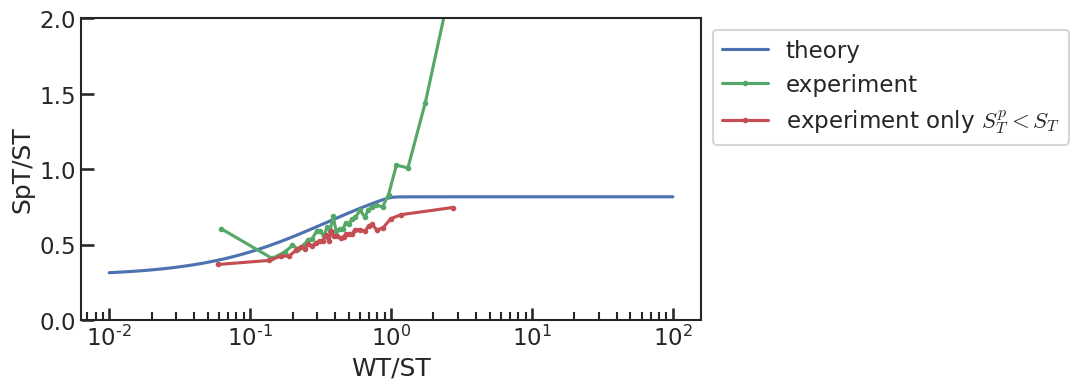

[4.20905144e-01 4.08906874e+00 3.23615369e-06]


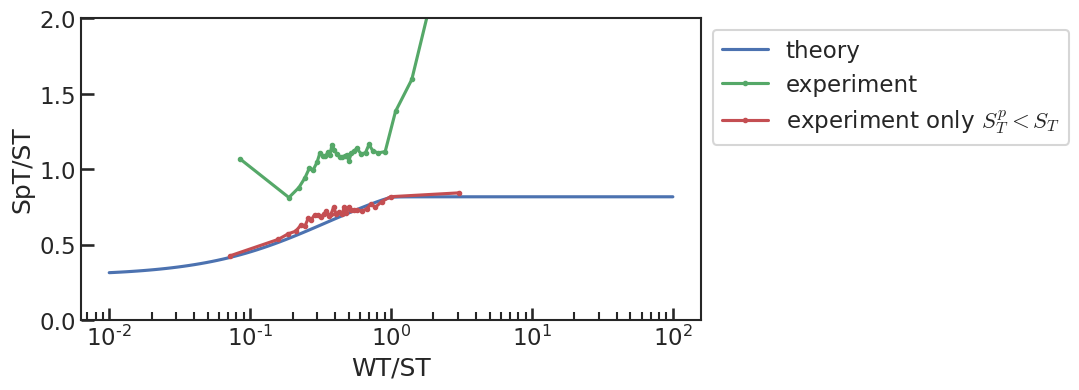

[4.20905144e-01 4.08906874e+00 7.33130603e+03]


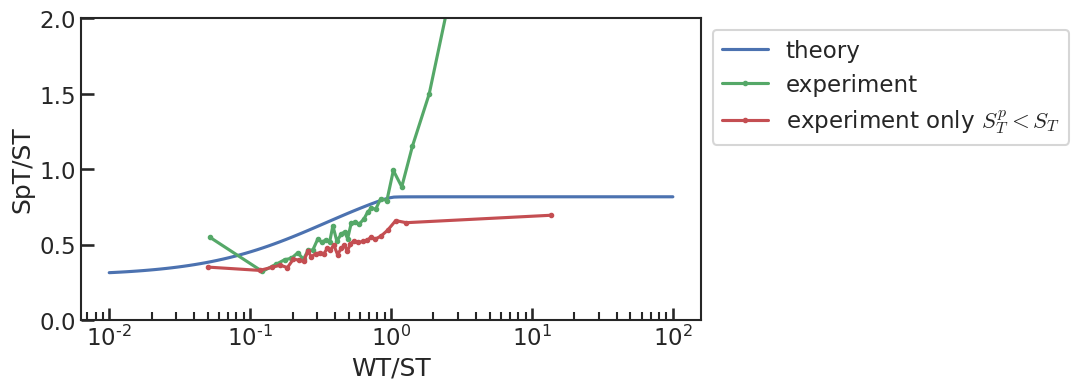

[0.42090514 4.08906874 0.07888482]


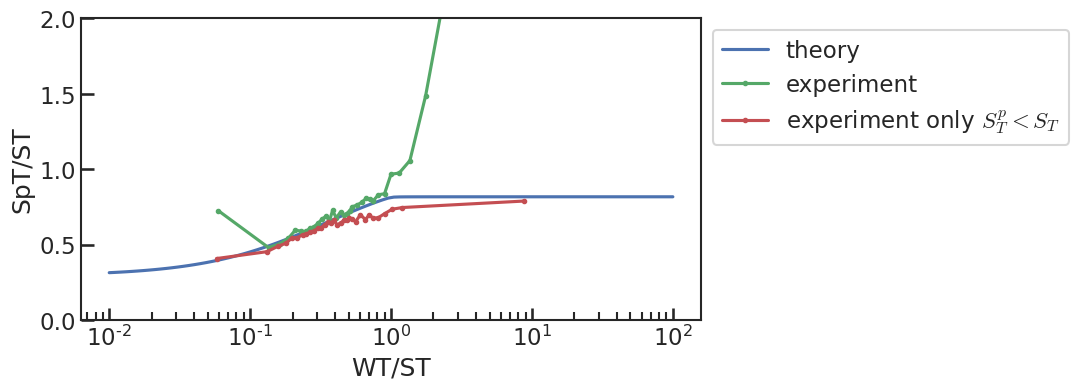

[0.42090514 4.08906874 0.18877464]


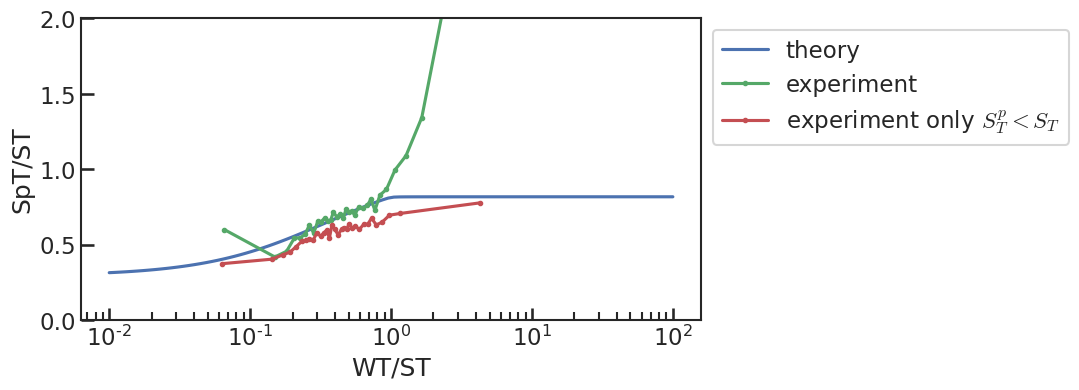

In [14]:
for i, (construct, group) in enumerate(df.groupby("dataset")):
    
    
#     noise_params = res.x[param_dict[construct][0:1]]
    model_params = 10**res.x[param_dict[construct][0:]]
    
    print(model_params)
    
#     model_params[0] = 0.0
#     model_params[1] = 0.5e1
    
#     phospho_scale = noise_params[0]

    phospho_scale = 1.0
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    
    
    ST = 1e3*model_params[2]*np.ones(100)
    WT = np.logspace(np.log10(1e3*model_params[2])-2, np.log10(1e3*model_params[2])+2, 100, base=10)
    
    SpT = pp.PushAmp().predict_all(np.asfortranarray(np.c_[WT, ST]), np.array(model_params))[:, 0]
    
    ax.plot(WT/ST, SpT/ST, 'b', label="theory")
    
    
    
    
#     df_tmp = group.query("SpT_conc <= ST_conc").copy().dropna()
    df_tmp = group.copy().dropna()
    df_tmp['ratio'] = df_tmp['WT_conc'] / df_tmp['ST_conc']
    
    bin_labels, edges = pd.qcut(df_tmp['ratio'], 32, labels=False, retbins=True)
    
    df_tmp['bin'] = bin_labels
    
    Sp_frac = df_tmp.groupby('bin')['Sp_frac_conc'].mean() 
    
    ax.plot((edges[1:]+edges[0:len(edges)-1])/2, Sp_frac, 'g.-', label="experiment", ms=6.0)
    
    
    
    df_tmp = group.query("SpT_conc <= ST_conc").copy().dropna()
#     df_tmp = group.copy().dropna()
    df_tmp['ratio'] = df_tmp['WT_conc'] / df_tmp['ST_conc']
    
    bin_labels, edges = pd.qcut(df_tmp['ratio'], 32, labels=False, retbins=True)
    
    df_tmp['bin'] = bin_labels
    
    Sp_frac = df_tmp.groupby('bin')['Sp_frac_conc'].mean() 
    
    ax.plot((edges[1:]+edges[0:len(edges)-1])/2, Sp_frac, 'r.-', label=r"experiment only $S^p_T < S_T$", ms=6.0)
    
    ax.set_xscale('log')
    
    ax.set_ylim(0, 2.0)
    
    ax.set_ylabel("SpT/ST")
    ax.set_xlabel("WT/ST")
    
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0, 0.0, 0.0))
    
    plt.show()

['I+E', 'S+A', 'S+E', 'E+E', 'RR+A']
[-5.489970861126802, -1.103006560257754, -0.724056347903474, 0.6100177664266768, 3.8651813484018582]


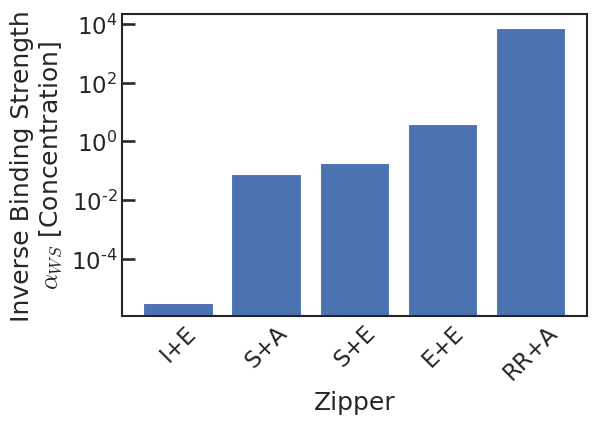

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

construct_list = list(param_dict.keys())

alphaWS_list = [res.x[param_dict[construct]][2] for construct in construct_list]

construct_list = [x for _, x in sorted(zip(alphaWS_list, construct_list))]
alphaWS_list = sorted(alphaWS_list)

print(construct_list)
print(alphaWS_list)

ax.bar(construct_list, 10**np.array(alphaWS_list))

ax.set_yscale('log')
ax.set_xlabel("Zipper")
ax.set_ylabel("Inverse Binding Strength\n" + r"$\alpha_{WS}$ [Concentration]")
plt.xticks(rotation=45)

plt.show()